Kozia, C. and Herzallah, R., 2021. Advanced Fusion and Empirical Mode Decomposition-Based Filtering Methods for Breathing Rate Estimation from Seismocardiogram Signals. Information, 12(9), p.368.

# IMPORTING LIBRARIES

In [1]:
import os
from kinopy.io import read_record
from scipy.signal import detrend, butter, sosfilt, resample, welch, find_peaks
from scipy import signal, integrate
from scipy.interpolate import interp1d
import pywt
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from psd2 import psd2
from sklearn.metrics import mean_absolute_error
import copy
import neurokit2 as nk
from PyEMD import EMD
from typing import Sequence, Optional, Literal, Tuple
from kinopy.commons.types import Number
from numpy import trapz
import scipy.stats as st

# DATA LOADING

In [2]:
main_path = "/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/"
path_all = []
for i in sorted(os.listdir(main_path)):
    sub_path = os.path.join(main_path, i)
    sub = sorted(os.listdir(sub_path))
    for k in sub:
        subsub_path = os.path.join(sub_path, k)
        subsub = sorted(os.listdir(subsub_path))
        if len(subsub) == 2:
            path_all.append((os.path.join(subsub_path, str(subsub[0]))))
            path_all.append((os.path.join(subsub_path, str(subsub[1]))))
        else:
            path_all.append((os.path.join(subsub_path, str(subsub[0]))))
            
path_all

['/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC10/K-ICB_A_BDC10_20190330-101553_gwoB4aykkTA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC9/K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC9/K-ICB_A_BDC9_20190331-112912_BKe5wrlWOhVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/FAM/K-ICB_A_FAM_20190330-100233_vk0azV9DkUKXi4',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT21/K-ICB_A_HDT21_20190429-110822_gwoxGB2nzSA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT5/K-ICB_A_HDT5_20190413-090257_BKe0M07rPhVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT56/K-ICB_A_HDT56_20190603-110736_gwokQXN5vFA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/R1/K-ICB_A_R1_20190609-131324_bB5V5zalQtYqid',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/R1/K-ICB_A_R1_20190609-132625_bB5V5pwQQSYqid',
 '/home/giuseppeditursi

In [3]:
measurement = path_all[1]
record = read_record(measurement)
record

<Record 'K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk' (signals: 3, segmentations: 0, metrics: 0)>
Meta Data:
    id                      K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk
    code                    BDC9
    date                    2019-03-31T11:15:11+00:00
    subject                 A | Male | 1.8m | 72.8kg
    phone                   iPhone | iOS N/A | sw:2018.0.3.2
    device                  1.06 | hw:2017.0 | fw:2018.0.4.0
Signals:
    'ecg'                   electric/ecg        (451.06s, 200Hz)
    'scg'                   mechanical/scg      (451.06s, 200Hz)
    'bcg'                   mechanical/bcg      (451.06s, 200Hz)

In [4]:
fs = 200

In [5]:
scg = record.signals["scg"]
scg

<Biosignal 'scg' mechanical/scg (451.06s, 200Hz)>
Subsignals:  dis, vel, acc
Dimensions:  (motion: 2, time: 90212, axis: 3)

In [6]:
x = 0
y = 1
z = 2

# Lin
typ = 0
s1 = detrend(scg.vel[typ][:,x])      
s2 = detrend(scg.vel[typ][:,y])      
s3 = detrend(scg.vel[typ][:,z])      

# Rot
typ = 1
s4 = detrend(scg.vel[typ][:,x])       
s5 = detrend(scg.vel[typ][:,y])        
s6 = detrend(scg.vel[typ][:,z])  

# DATA PROCESSING

## RESPIRATION EXTRACTION

In [7]:
time_frame = [10.806, 50.806]

### Empirical Mode Decompositon

The EMD method can possibly extract signals which are hidden in an observed signal.
In order to extract the respiration signal, first the Intrinsic Mode Functions (IMFs) of the SCG signal are obtained after applying the EMD method. The selection of the respiratory IMF is then based on a spectral analysis. The IMF which contains the peak frequency that lies within the respiratory frequency range is set to be the EMD-Derived Respiration (EMDDR) signal.

In [8]:
emd = EMD()
IMFs = emd(s6)

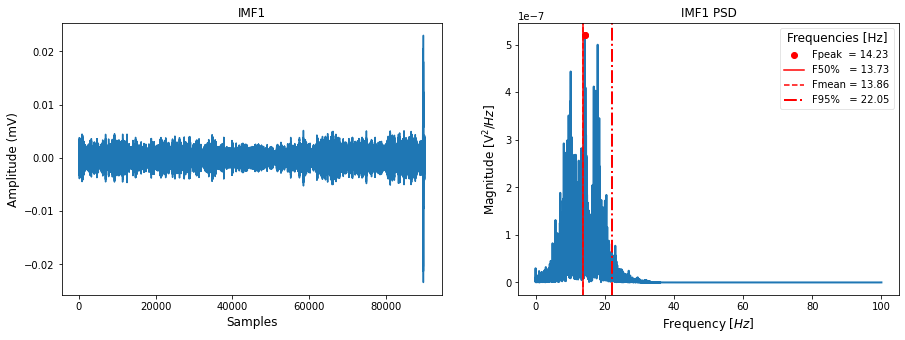

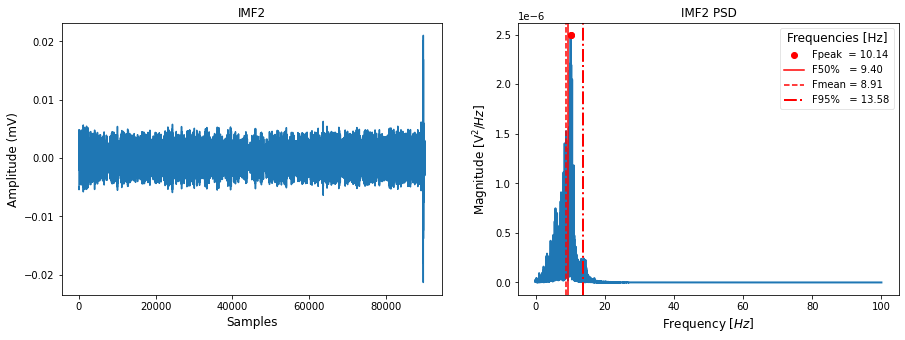

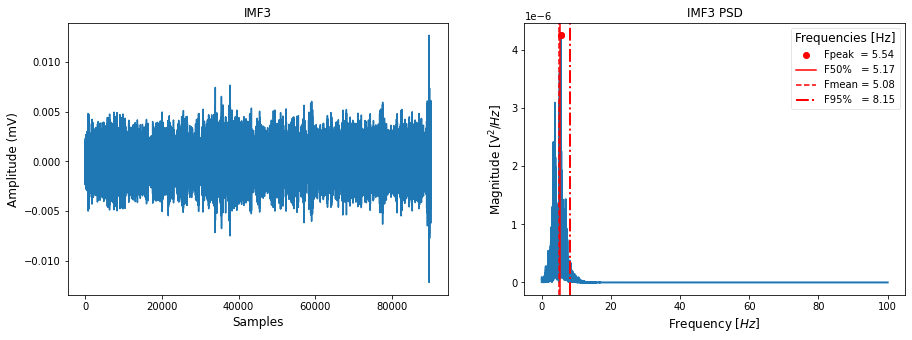

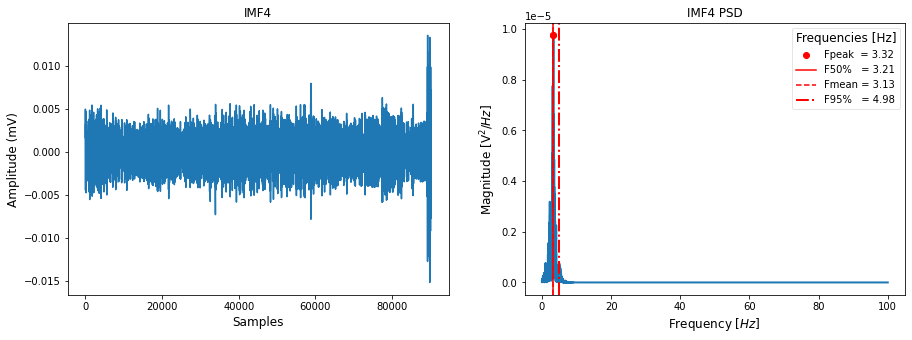

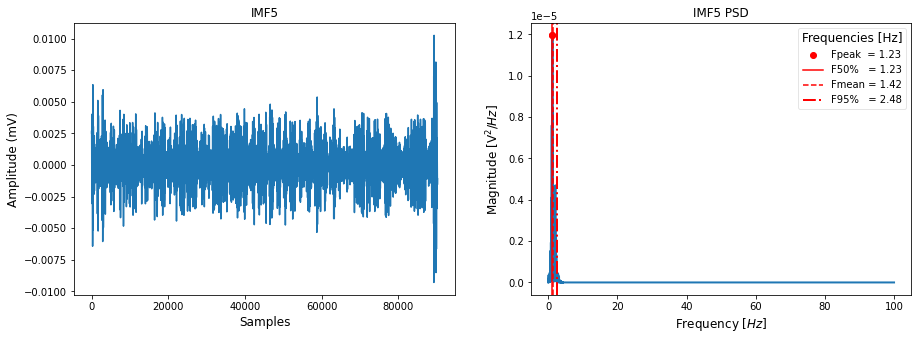

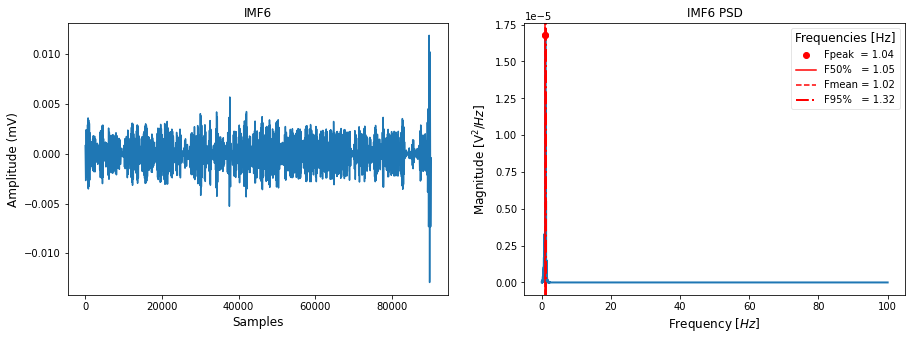

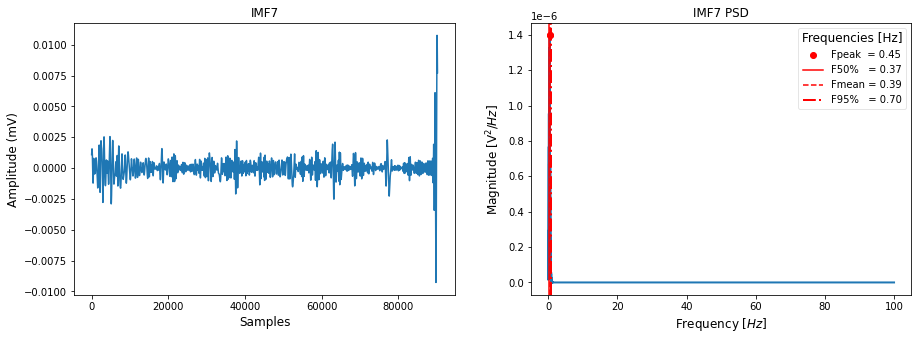

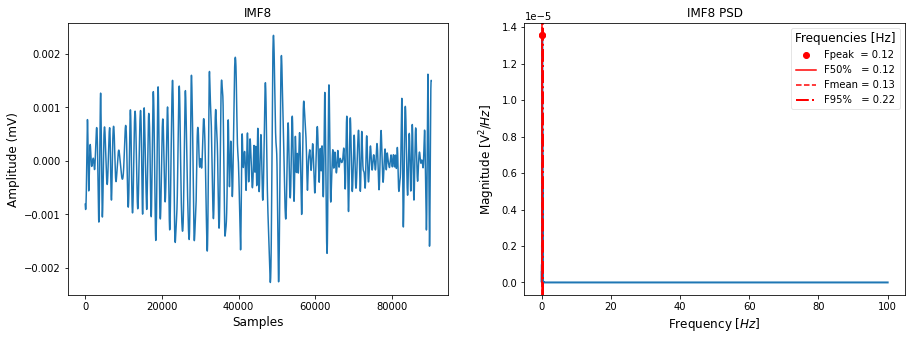

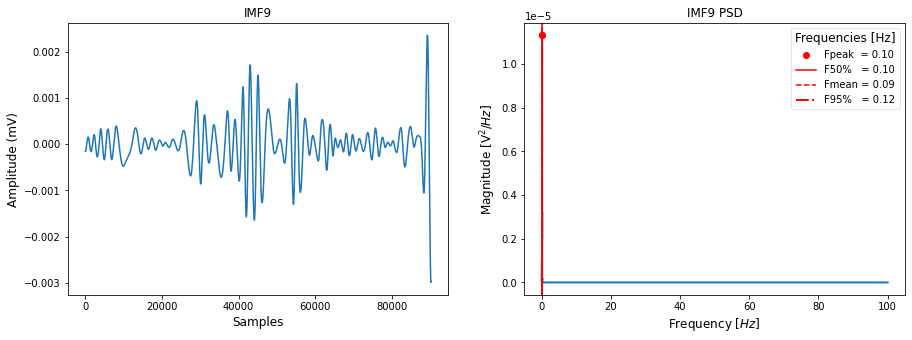

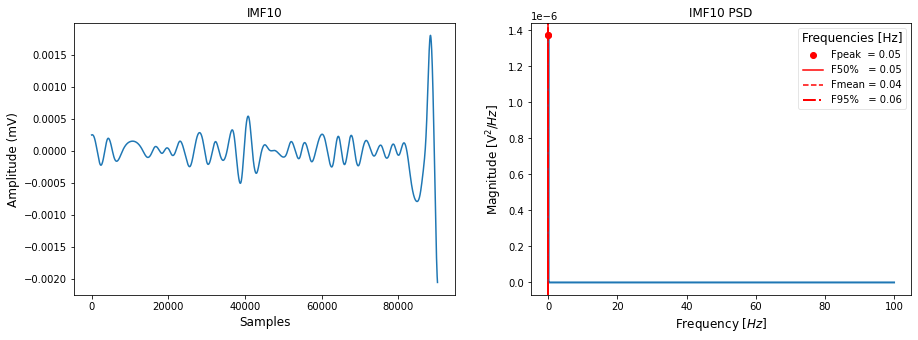

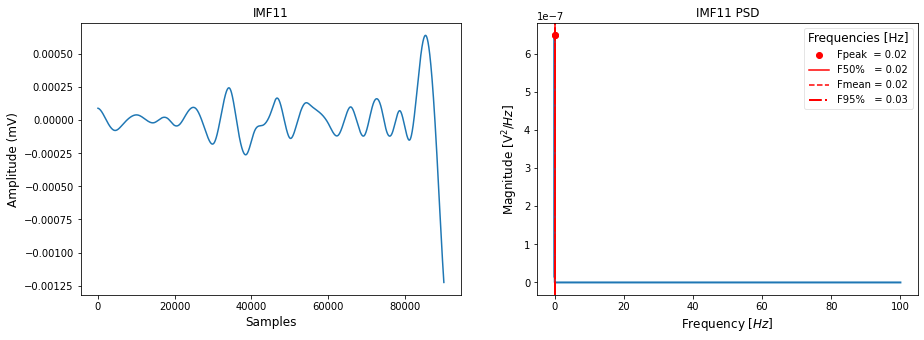

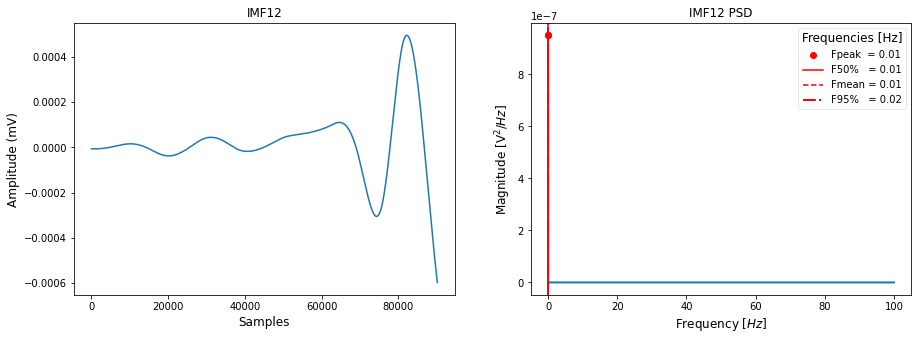

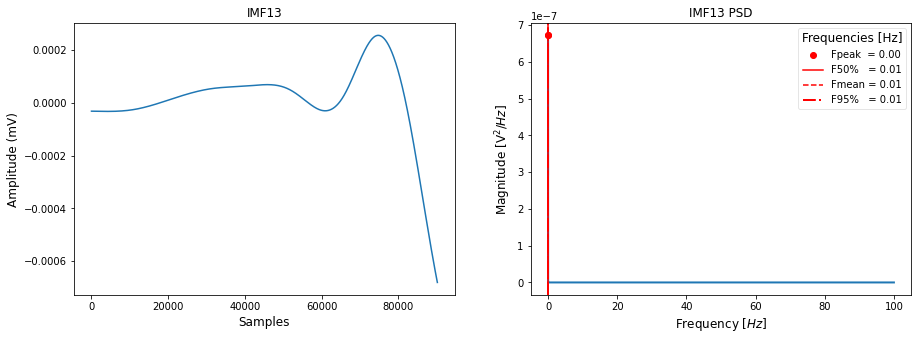

In [9]:
fmax_all = []

for idk, k in enumerate(IMFs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(IMFs[idk])
    ax1.set_xlabel('Samples', fontsize=12)
    ax1.set_ylabel('Amplitude (mV)', fontsize=12)
    ax1.set_title("IMF" +str(idk+1), fontsize=12)

    nperseg = np.ceil(len(IMFs[idk]) / 2)
    f, P = welch(IMFs[idk]-np.mean(IMFs[idk]), fs=fs, window='hanning', nperseg=nperseg, nfft=8*nperseg, detrend='constant')
    Area = integrate.cumtrapz(P, f, initial=0)
    Ptotal = Area[-1]
    mpf = integrate.trapz(f * P, f) / Ptotal  # mean power frequency
    fmax = f[np.argmax(P)]
    # frequency percentiles
    inds = [0]
    Area = 100 * Area / Ptotal  # + 10 * np.finfo(np.float).eps
    for i in range(1, 101):
        inds.append(np.argmax(Area[inds[-1]:] >= i) + inds[-1])
    fpcntile = f[inds]

    scales = 'linear'
    units = 'V'
    xlim = None
    if scales.lower() == 'semilogy' or scales.lower() == 'loglog':
        ax2.set_yscale('log')
    if scales.lower() == 'semilogx' or scales.lower() == 'loglog':
        ax2.set_xscale('log')
    ax2.plot(f, P, linewidth=2)
    ylim = ax2.get_ylim()
    ax2.plot([fmax, fmax], [np.max(P), np.max(P)], 'ro', label='Fpeak  = %.2f' % fmax)
    ax2.plot([fpcntile[50], fpcntile[50]], ylim, 'r', lw=1.5, label='F50%%   = %.2f' % fpcntile[50])
    ax2.plot([mpf, mpf], ylim, 'r--', lw=1.5, label='Fmean = %.2f' % mpf)
    ax2.plot([fpcntile[95], fpcntile[95]], ylim, 'r-.', lw=2, label='F95%%   = %.2f' % fpcntile[95])
    leg = ax2.legend(loc='best', numpoints=1, framealpha=.5, title='Frequencies [Hz]')
    plt.setp(leg.get_title(), fontsize=12)
    ax2.set_xlabel('Frequency [$Hz$]', fontsize=12)
    ax2.set_ylabel('Magnitude [%s$^2/Hz$]' % units, fontsize=12)
    ax2.set_title('IMF' +str(idk+1)+  ' PSD', fontsize=12)
    if xlim:
        ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    
    fmax_all.append(fmax)
    
fmax_all = np.array(fmax_all)

It can be observed that the frequency content of the lower order IMFs, which represent the fast oscillations of the signal, is widely spread and there is no clear dominant frequency, thus these IMFs are excluded from our analysis in order to estimate the BR. 
The last IMFs represent the slow oscillations that can be found in the SCG signal. Closer inspection reveals that the spectrum of IMF7, IMF8 have a dominant frequency which lies between 0.1 Hz and 0.7 Hz (6 to 42 breaths per minute).

In [10]:
indices = np.where([(x>=0.1) & (x<=0.7) for x in fmax_all])[0]
fresp_cand = fmax_all[[(x>=0.1) & (x<=0.7) for x in fmax_all]]
resp_cand = IMFs[[(x>=0.1) & (x<=0.7) for x in fmax_all]]

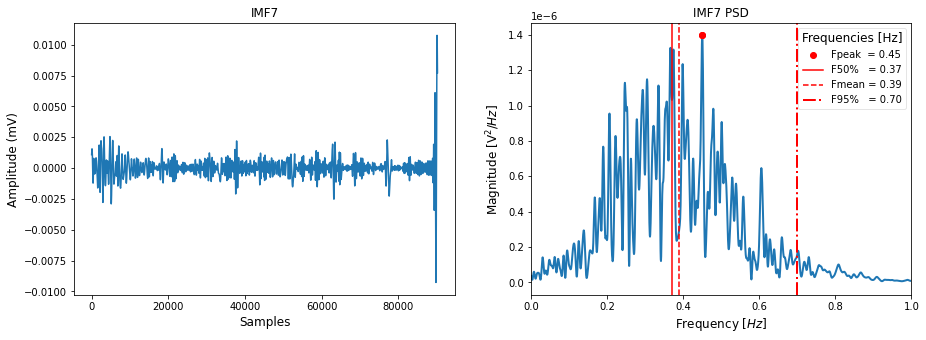

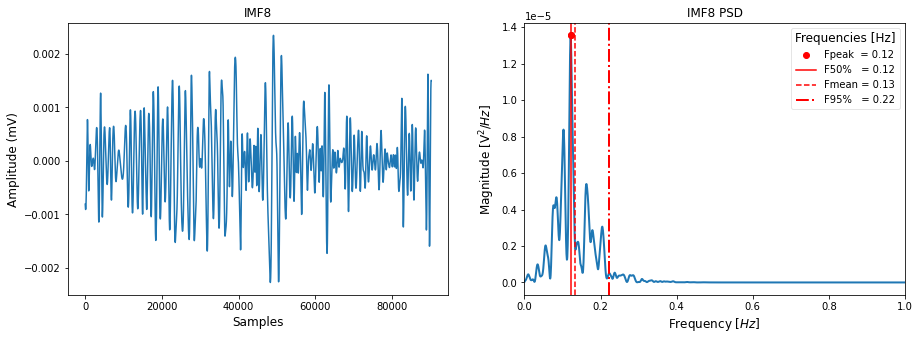

In [11]:
f95_all = []

for idk, k in enumerate(resp_cand):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(resp_cand[idk])
    ax1.set_xlabel('Samples', fontsize=12)
    ax1.set_ylabel('Amplitude (mV)', fontsize=12)
    ax1.set_title("IMF" +str(indices[idk]+1), fontsize=12)

    nperseg = np.ceil(len(resp_cand[idk]) / 2)
    f, P = welch(resp_cand[idk]-np.mean(resp_cand[idk]), fs=fs, window='hanning', nperseg=nperseg, nfft=8*nperseg, detrend='constant')
    Area = integrate.cumtrapz(P, f, initial=0)
    Ptotal = Area[-1]
    mpf = integrate.trapz(f * P, f) / Ptotal  # mean power frequency
    fmax = f[np.argmax(P)]
    # frequency percentiles
    inds = [0]
    Area = 100 * Area / Ptotal  # + 10 * np.finfo(np.float).eps
    for i in range(1, 101):
        inds.append(np.argmax(Area[inds[-1]:] >= i) + inds[-1])
    fpcntile = f[inds]

    scales = 'linear'
    units = 'V'
    xlim = (0, 1) 
    if scales.lower() == 'semilogy' or scales.lower() == 'loglog':
        ax2.set_yscale('log')
    if scales.lower() == 'semilogx' or scales.lower() == 'loglog':
        ax2.set_xscale('log')
    ax2.plot(f, P, linewidth=2)
    ylim = ax2.get_ylim()
    ax2.plot([fmax, fmax], [np.max(P), np.max(P)], 'ro', label='Fpeak  = %.2f' % fmax)
    ax2.plot([fpcntile[50], fpcntile[50]], ylim, 'r', lw=1.5, label='F50%%   = %.2f' % fpcntile[50])
    ax2.plot([mpf, mpf], ylim, 'r--', lw=1.5, label='Fmean = %.2f' % mpf)
    ax2.plot([fpcntile[95], fpcntile[95]], ylim, 'r-.', lw=2, label='F95%%   = %.2f' % fpcntile[95])
    leg = ax2.legend(loc='best', numpoints=1, framealpha=.5, title='Frequencies [Hz]')
    plt.setp(leg.get_title(), fontsize=12)
    ax2.set_xlabel('Frequency [$Hz$]', fontsize=12)
    ax2.set_ylabel('Magnitude [%s$^2/Hz$]' % units, fontsize=12)
    ax2.set_title('IMF' +str(indices[idk]+1)+  ' PSD', fontsize=12)
    if xlim:
        ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
       
    f95_all.append(fpcntile[95])

It can be observed that the dominant frequency of IMF8 is more distinct, compared to the frequency peaks of IMF7.

(-6.778643669611571e-07, 1.4235151706184297e-05)

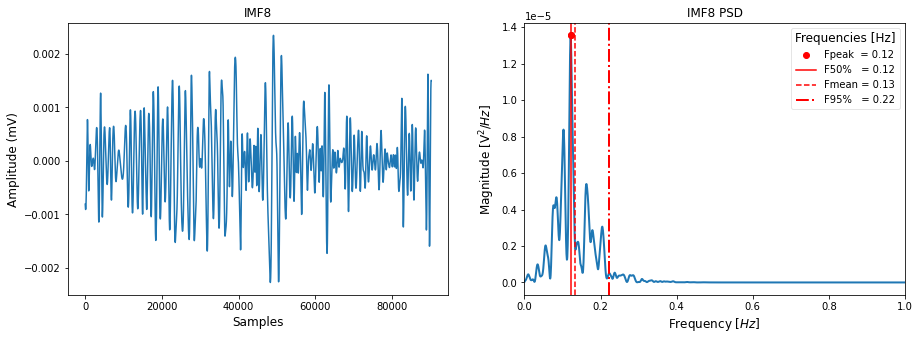

In [12]:
resp = resp_cand[np.argmin(f95_all)]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(resp)
ax1.set_xlabel('Samples', fontsize=12)
ax1.set_ylabel('Amplitude (mV)', fontsize=12)
ax1.set_title("IMF" +str(indices[np.argmin(f95_all)]+1), fontsize=12)

nperseg = np.ceil(len(resp) / 2)
f, P = welch(resp-np.mean(resp), fs=fs, window='hanning', nperseg=nperseg, nfft=8*nperseg, detrend='constant')
Area = integrate.cumtrapz(P, f, initial=0)
Ptotal = Area[-1]
mpf = integrate.trapz(f * P, f) / Ptotal  # mean power frequency
fmax = f[np.argmax(P)]
# frequency percentiles
inds = [0]
Area = 100 * Area / Ptotal  # + 10 * np.finfo(np.float).eps
for i in range(1, 101):
    inds.append(np.argmax(Area[inds[-1]:] >= i) + inds[-1])
fpcntile = f[inds]

scales = 'linear'
units = 'V'
xlim = (0, 1) 
if scales.lower() == 'semilogy' or scales.lower() == 'loglog':
    ax2.set_yscale('log')
if scales.lower() == 'semilogx' or scales.lower() == 'loglog':
    ax2.set_xscale('log')
ax2.plot(f, P, linewidth=2)
ylim = ax2.get_ylim()
ax2.plot([fmax, fmax], [np.max(P), np.max(P)], 'ro', label='Fpeak  = %.2f' % fmax)
ax2.plot([fpcntile[50], fpcntile[50]], ylim, 'r', lw=1.5, label='F50%%   = %.2f' % fpcntile[50])
ax2.plot([mpf, mpf], ylim, 'r--', lw=1.5, label='Fmean = %.2f' % mpf)
ax2.plot([fpcntile[95], fpcntile[95]], ylim, 'r-.', lw=2, label='F95%%   = %.2f' % fpcntile[95])
leg = ax2.legend(loc='best', numpoints=1, framealpha=.5, title='Frequencies [Hz]')
plt.setp(leg.get_title(), fontsize=12)
ax2.set_xlabel('Frequency [$Hz$]', fontsize=12)
ax2.set_ylabel('Magnitude [%s$^2/Hz$]' % units, fontsize=12)
ax2.set_title('IMF' +str(indices[np.argmin(f95_all)]+1)+  ' PSD', fontsize=12)
if xlim:
    ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

### Cleaning

Khodadad et al. (2018) https://iopscience.iop.org/article/10.1088/1361-6579/aad7e6/meta

BioSPPy https://github.com/PIA-Group/BioSPPy/blob/master/biosppy/signals/resp.py

Clean a respiration signal using different sets of parameters, such as 'khodadad2018' (linear detrending followed by a fifth order 2Hz low-pass IIR Butterworth filter) or 'BioSPPy' (second order 0.1 - 0.35 Hz bandpass Butterworth filter followed by a constant detrending).

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

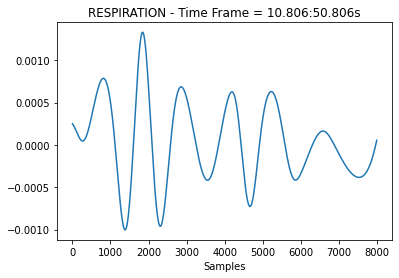

In [13]:
resp = nk.rsp.rsp_clean(resp)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Detrending

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

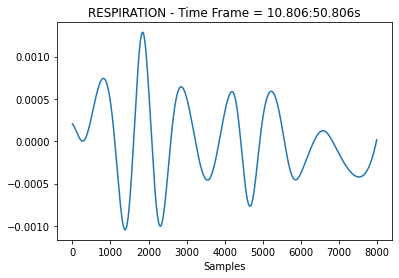

In [14]:
resp = detrend(resp)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Normalization

In [15]:
def scale_normalization(
    arr: np.ndarray,
    mode: Literal["range", "sum", "rss", "rms"] = "range",
    rg: Optional[Tuple[float, float]] = None,
) -> np.ndarray:
    """
    1D array
    """
    mx = np.max(arr)
    mn = np.min(arr)
    d = mx - mn
    if d == 0:
        return np.zeros_like(arr)
    s = arr - mn
    if mode == "range":
        if rg is None:
            rg = 0.0, 1.0
        ba = rg[1] - rg[0]
        a = rg[0]
        return (s * ba / d) + a
    elif mode == "sum":
        return s / np.sum(s)
    elif mode == "rss":
        return s / np.sqrt(np.sum(np.square(s)))
    elif mode == "rms":
        return s / np.sqrt(np.sum(np.square(s)) / len(s))

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

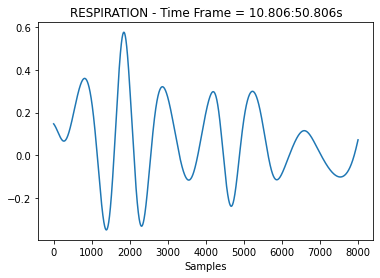

In [16]:
resp = scale_normalization(resp, rg=(-1, 1))
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Standardization

In [17]:
def interquartile_range(
    arr: np.ndarray, q: Optional[Sequence[Number]] = None, axis: int = 0
) -> float:
    """
    1D array
    """
    if q is None:
        q = [25, 75]
    return st.iqr(arr, axis=axis, rng=q, nan_policy="omit")

def scale_standardization_robust(
    arr: np.ndarray, q: Optional[Sequence[Number]] = None, axis: int = 0
) -> np.ndarray:
    return (arr - np.median(arr, axis=axis)) / interquartile_range(arr, q, axis=axis)

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

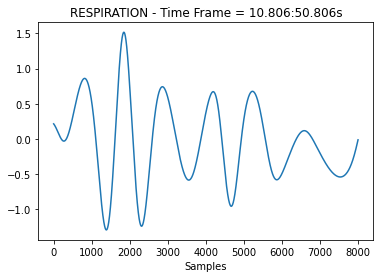

In [18]:
resp = scale_standardization_robust(resp)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Correction Respiration Sign

In [19]:
def _correct_rsp_sign(
    rsp: np.ndarray, fs: int, distance_ms: int, prominence: float
) -> np.ndarray:
    distance = int(distance_ms * fs / 1000)
    rsp_max_idx, _ = find_peaks(rsp, distance=distance, prominence=prominence)
    rsp_min_idx, _ = find_peaks(-rsp, distance=distance, prominence=prominence)

    i = 0
    j = 0
    lengths_min_max = []
    lengths_max_min = []

    prev_min_max = False
    prev_max_min = False

    while i < len(rsp_min_idx) and j < len(rsp_max_idx):
        min_i = rsp_min_idx[i]
        max_j = rsp_max_idx[j]

        if min_i < max_j:
            length = max_j - min_i
            if not prev_min_max:
                lengths_min_max.append(length)
            prev_min_max = True
            prev_max_min = False
            i += 1
        else:
            length = min_i - max_j
            if not prev_max_min:
                lengths_max_min.append(length)
            prev_min_max = False
            prev_max_min = True
            j += 1

    length_med_min_max = np.median(lengths_min_max)
    length_med_max_min = np.median(lengths_max_min)

    if length_med_min_max > length_med_max_min:
        rsp_corr = -rsp
    else:
        rsp_corr = rsp

    return rsp_corr

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

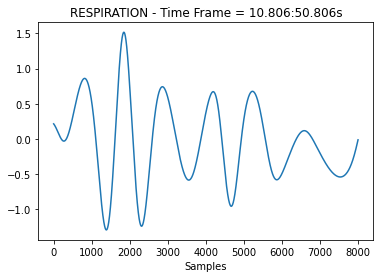

In [20]:
distance_ms = 1000
prominence = 0.25
resp = _correct_rsp_sign(resp, fs, distance_ms=distance_ms, prominence=prominence)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

## RESPIRATION PERIOD COMPUTATION

In [21]:
time_points = [10.806, 50.806, 110.806, 190.806, 290.806]
time_frames = [[time_points[i], time_points[i + 1]]
        for i in range(len(time_points) - 1)]

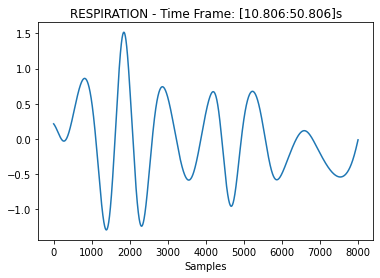

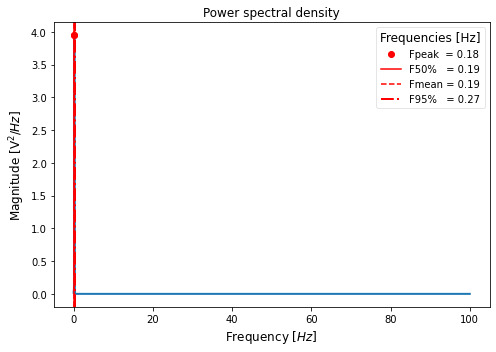

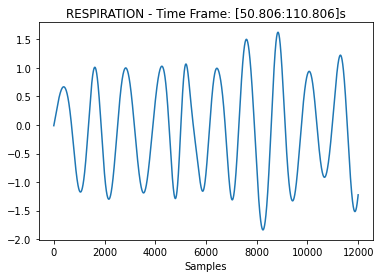

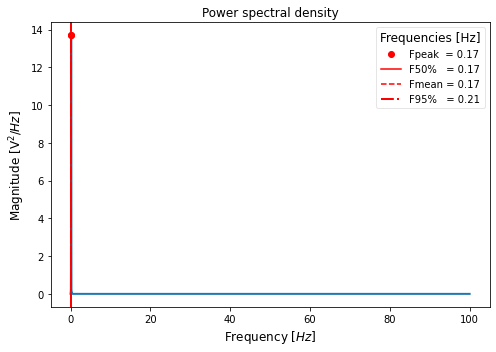

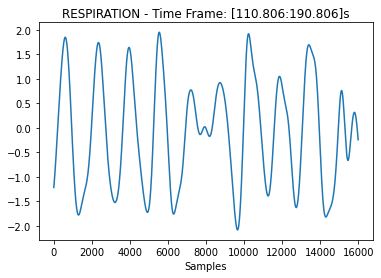

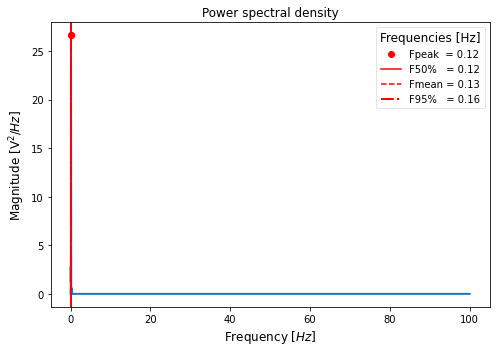

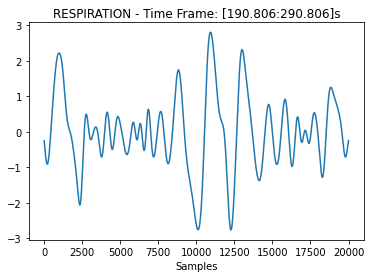

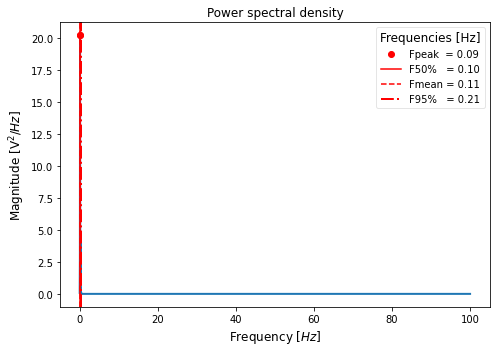

In [22]:
resp_period_all_comp = []
for k in time_frames:
    resp_cut = resp[int(k[0]*fs):int(k[1]*fs)]
    plt.figure()
    plt.plot(resp_cut)
    plt.xlabel('Samples')
    plt.title('RESPIRATION - Time Frame: [' +str(k[0])+ ':' +str(k[1])+ ']s')
    fpcntile, mpf, fmax, Ptotal, f, P = psd2(resp_cut-np.mean(resp_cut), fs=fs, nfft=8*np.ceil(len(resp_cut)/2), show=True)
    if fmax==0:
        resp_period = 0
    else:
        resp_period = 1/fmax
    resp_period_all_comp.append(resp_period)

Text(0.5, 1.0, 'Sub-A/BDC9/K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk\nMAE: 0.58s')

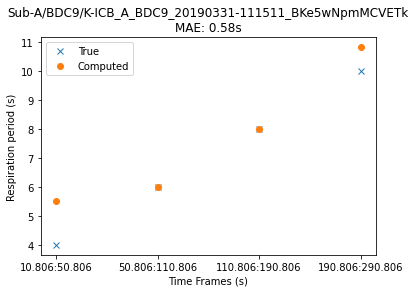

In [23]:
main_path = os.path.normpath(measurement)
sec_path = main_path.split(os.sep)
sec_path = sec_path[7]+'/'+sec_path[8]+'/'+sec_path[9]

resp_period_all_true = [4, 6, 8, 10]
err = mean_absolute_error(resp_period_all_true, resp_period_all_comp)
plt.figure()
x = np.array([0,1,2,3])
my_xticks = ['10.806:50.806','50.806:110.806','110.806:190.806','190.806:290.806']
plt.xticks(x, my_xticks)
plt.plot(my_xticks, resp_period_all_true, 'x')
plt.plot(my_xticks, resp_period_all_comp, 'o')
plt.xlabel('Time Frames (s)')
plt.ylabel("Respiration period (s)")
plt.legend(['True', 'Computed'])
plt.title(sec_path+ '\nMAE: ' +str(format(err, ".2f"))+ 's')

For all measurements.

In [24]:
del path_all[39]
del path_all[41]
del path_all[49]
del path_all[52]
del path_all[56]
del path_all[58]
del path_all[90]
del path_all[109]
del path_all[114]
del path_all[114]
del path_all[178]
del path_all[217]
del path_all[221]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/tmp/ipykernel_12190/2331959077.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252


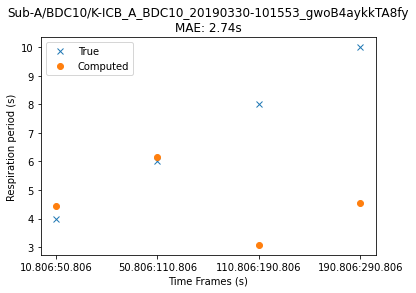

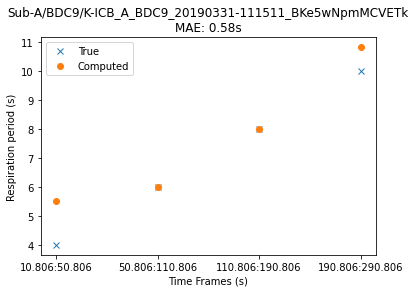

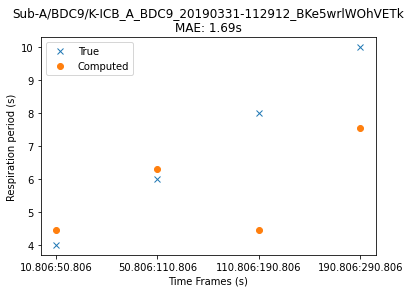

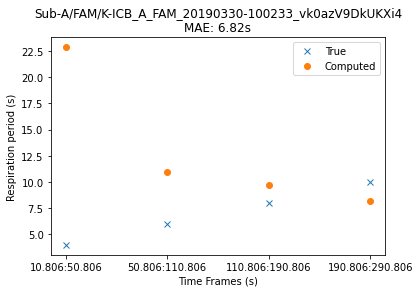

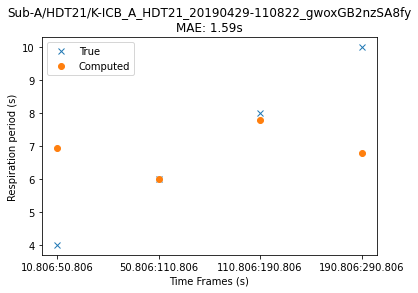

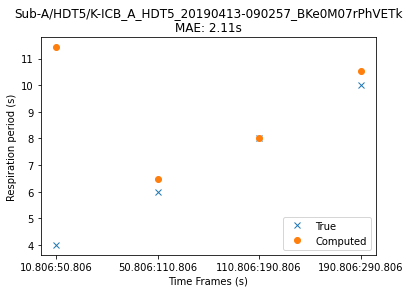

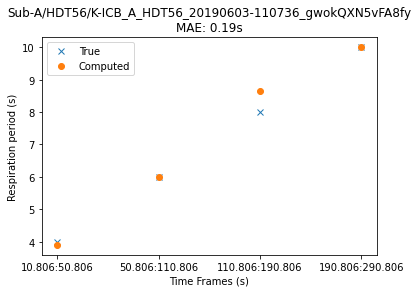

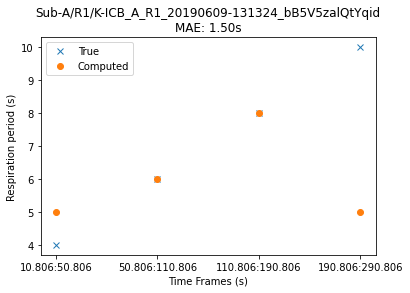

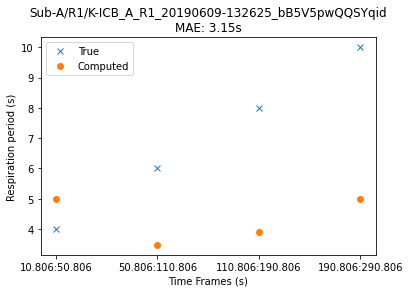

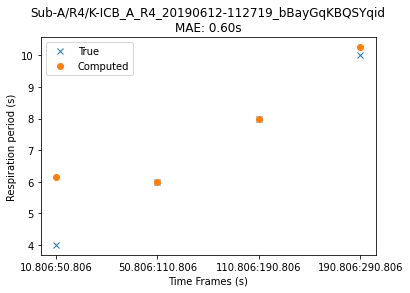

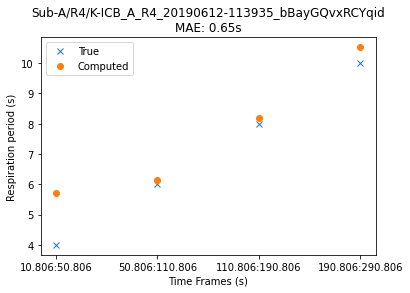

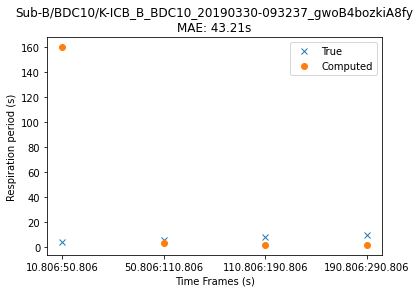

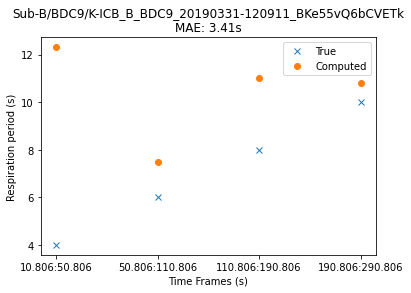

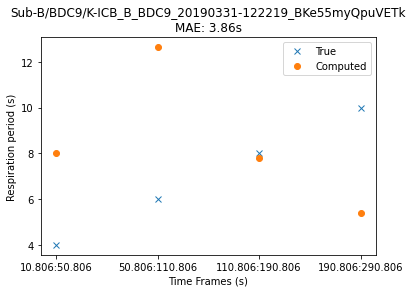

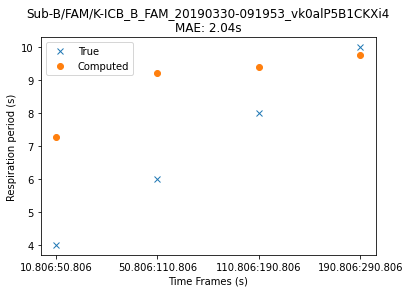

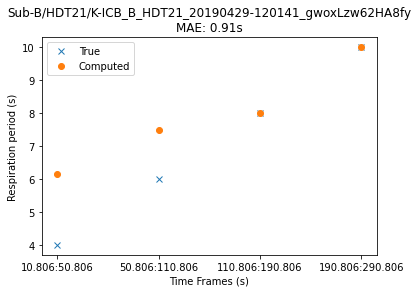

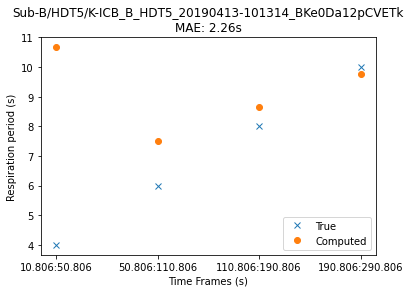

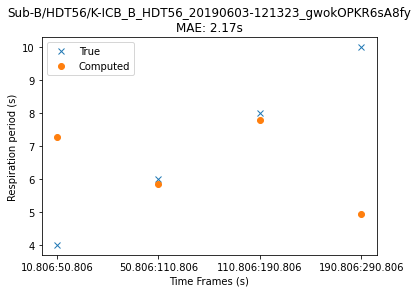

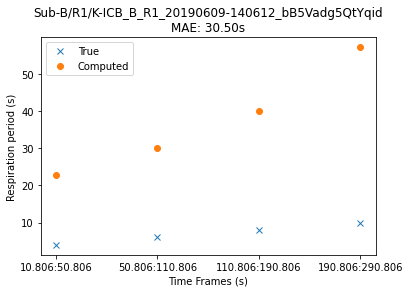

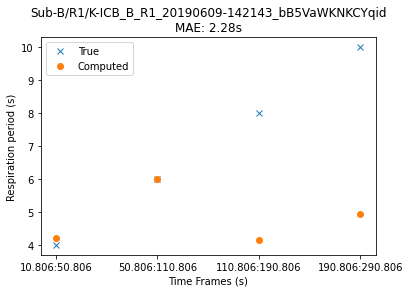

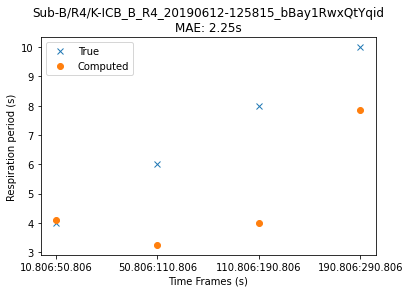

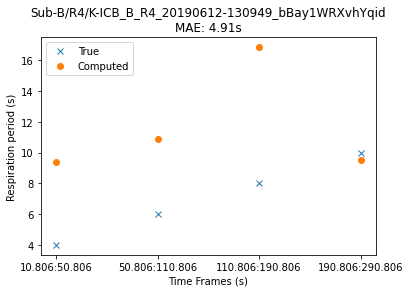

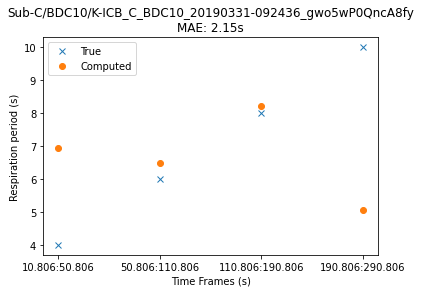

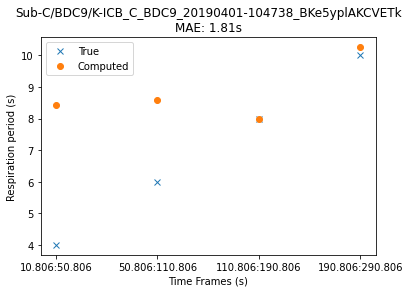

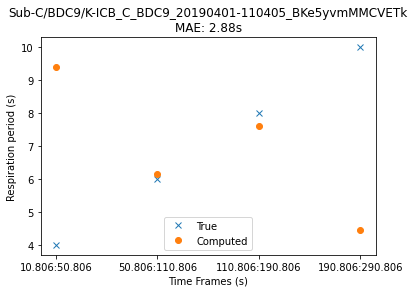

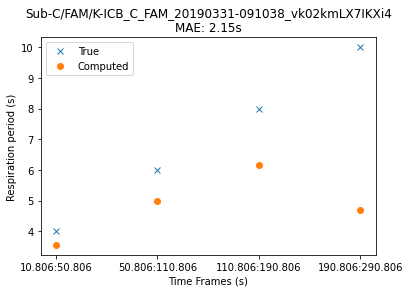

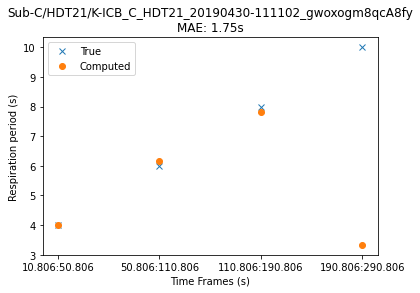

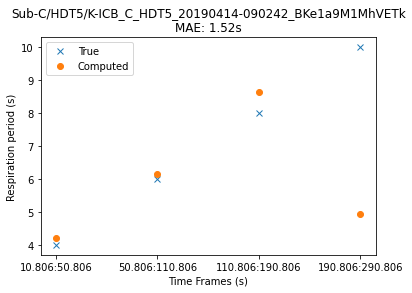

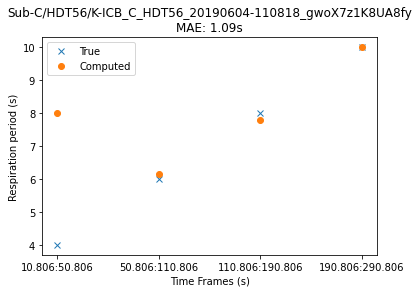

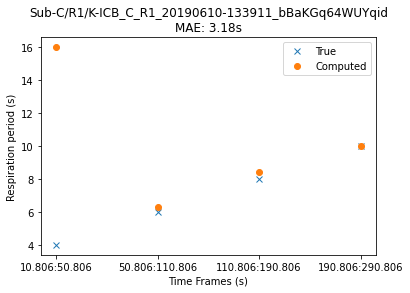

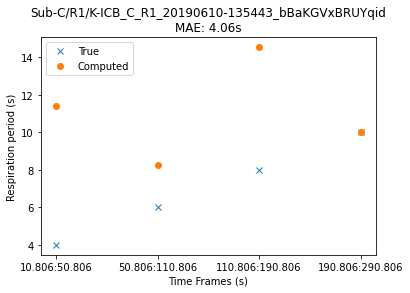

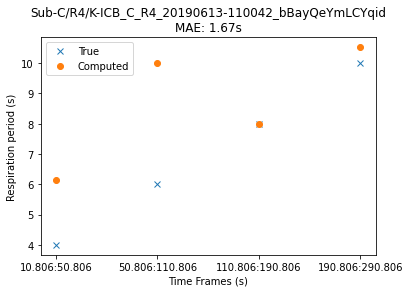

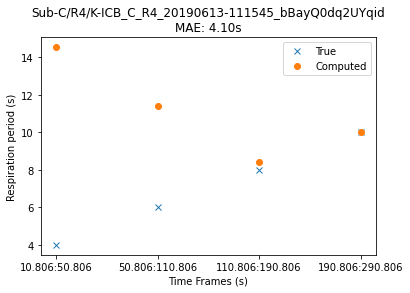

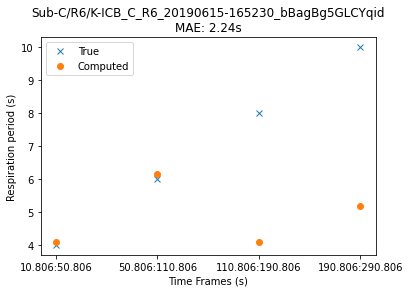

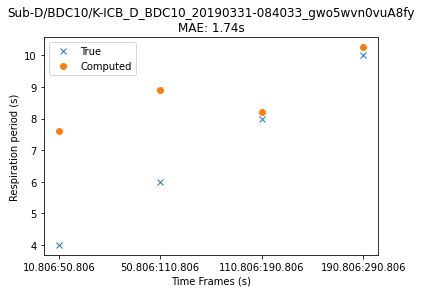

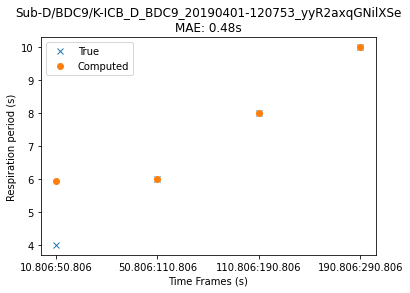

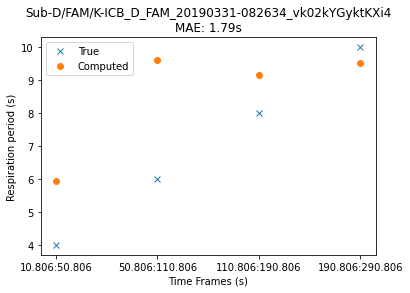

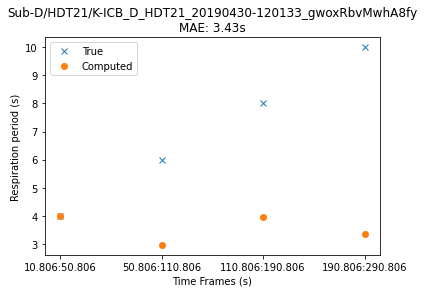

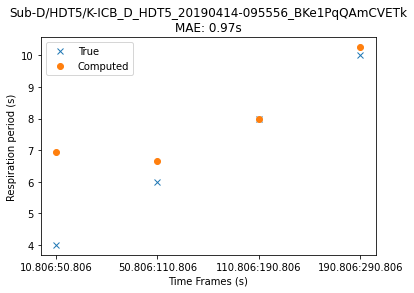

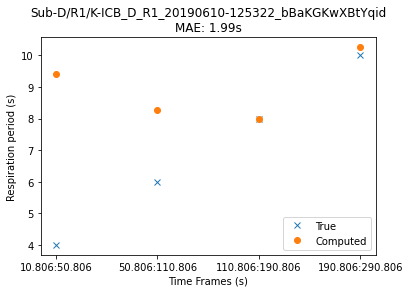

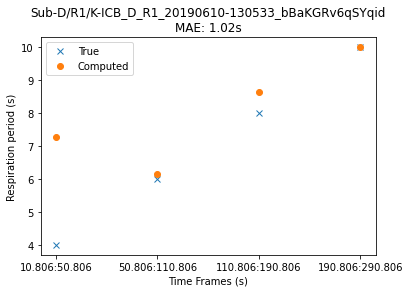

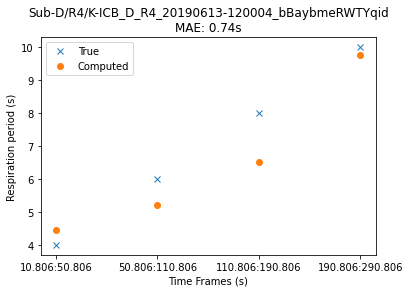

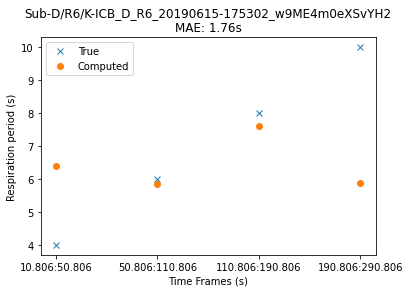

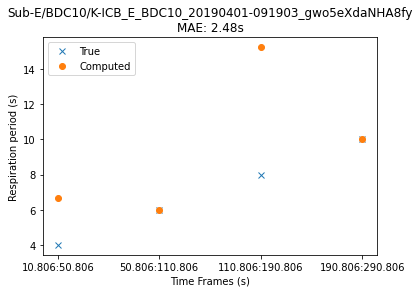

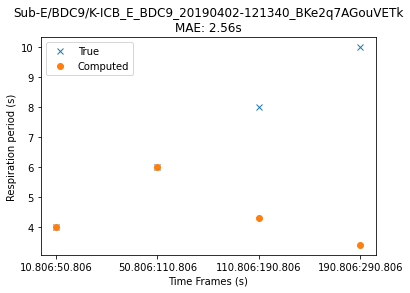

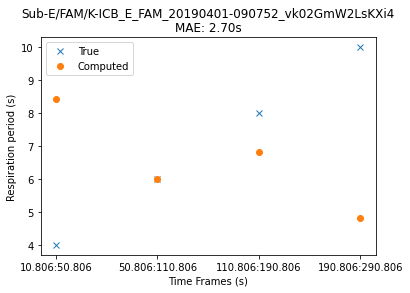

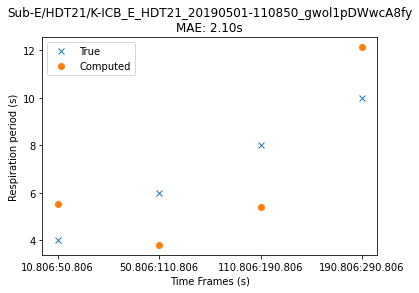

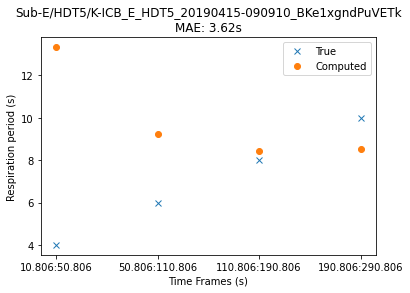

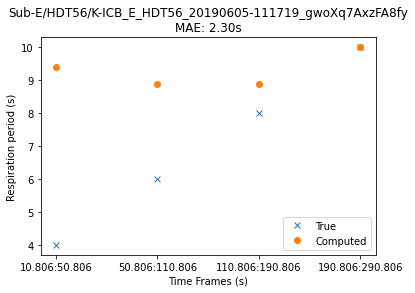

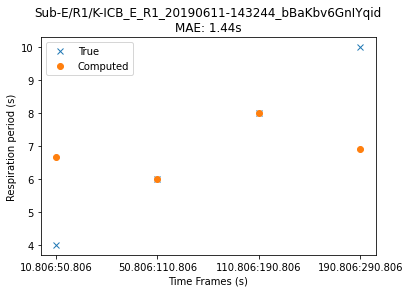

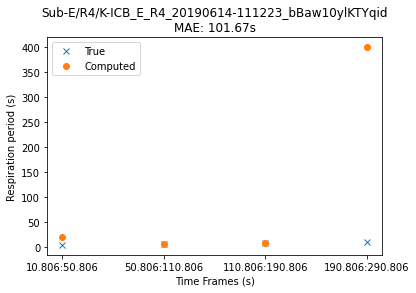

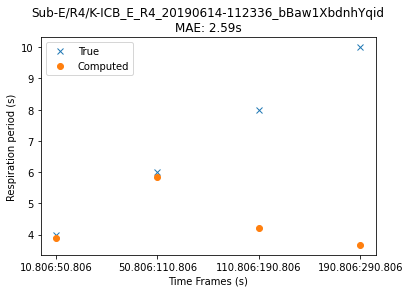

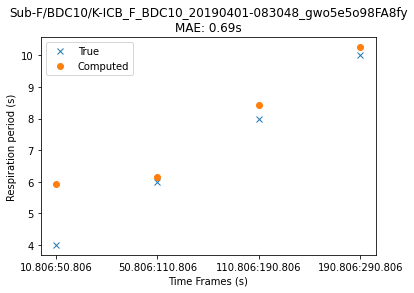

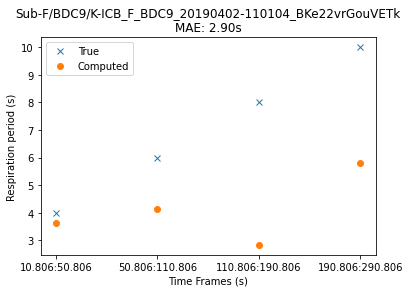

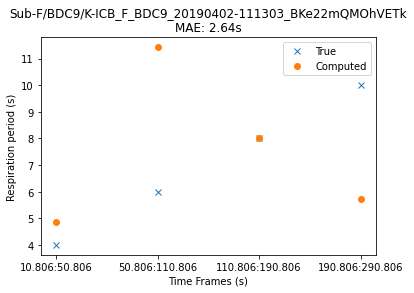

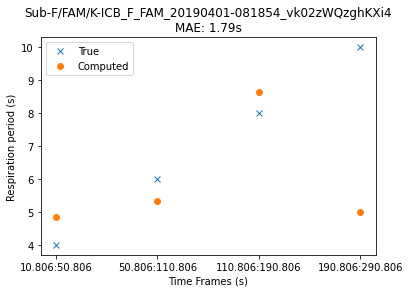

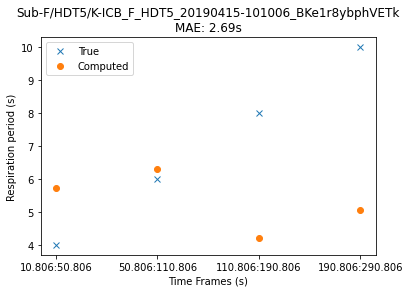

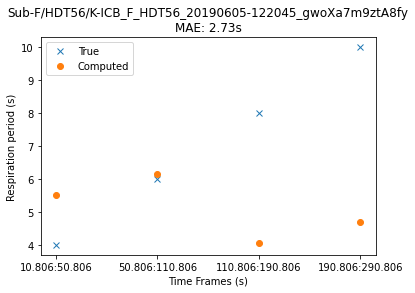

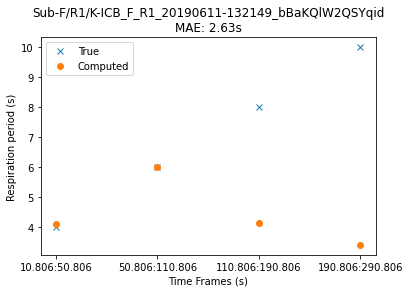

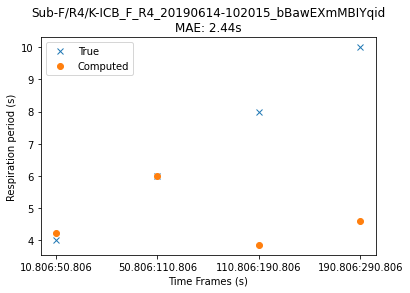

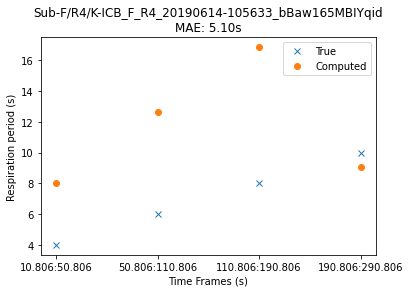

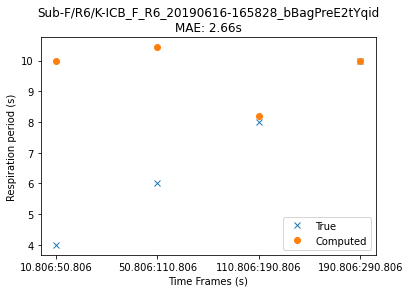

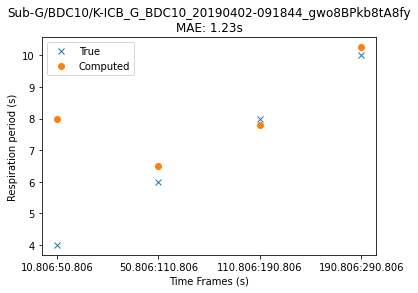

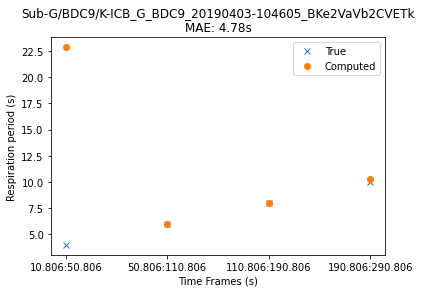

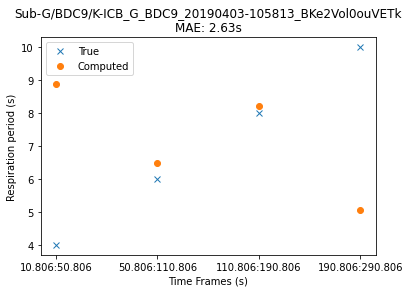

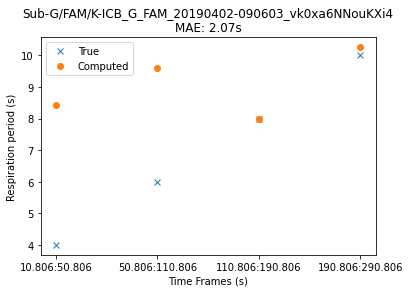

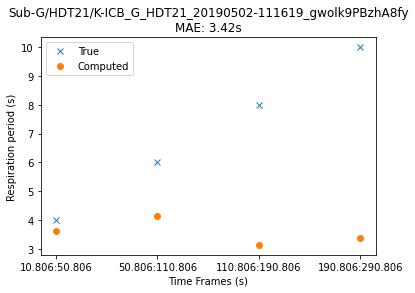

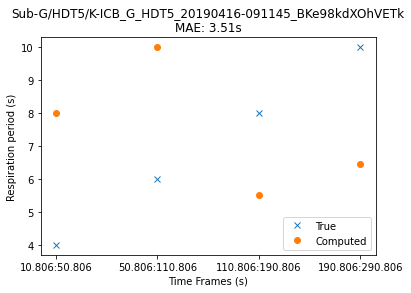

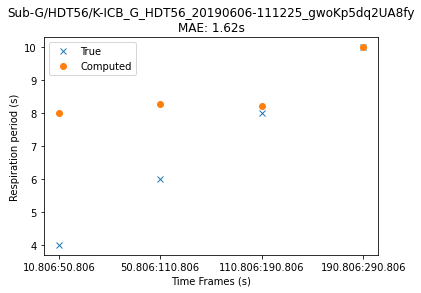

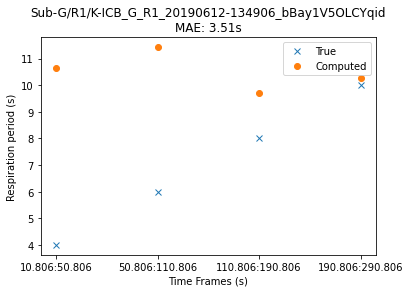

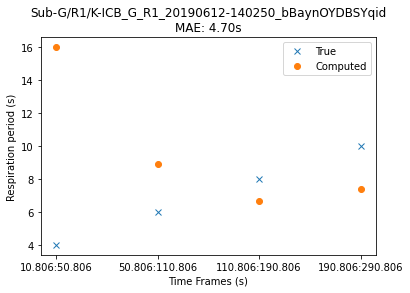

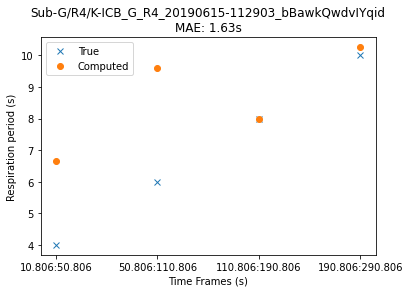

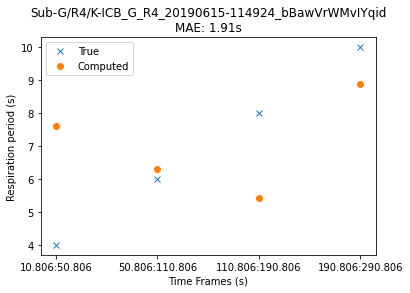

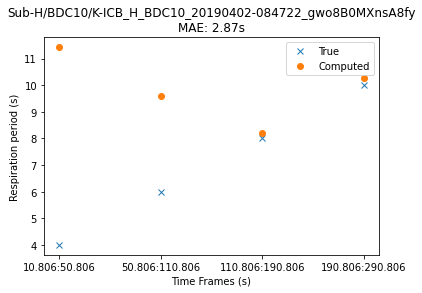

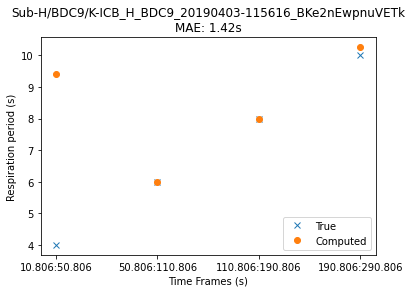

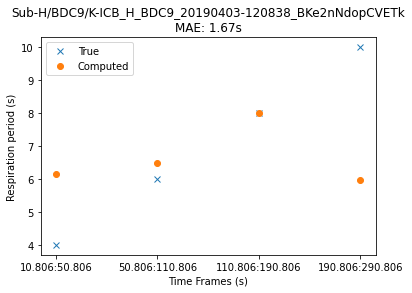

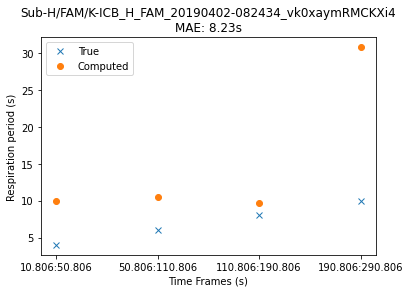

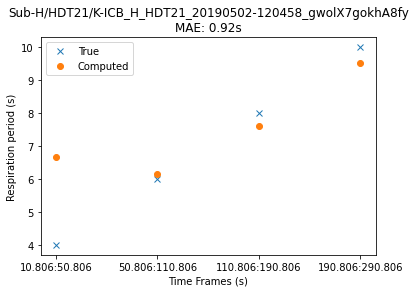

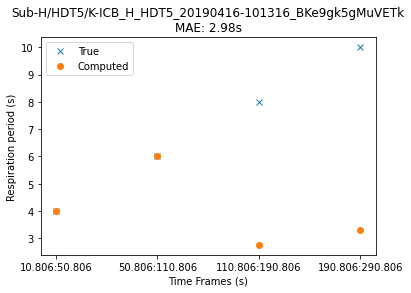

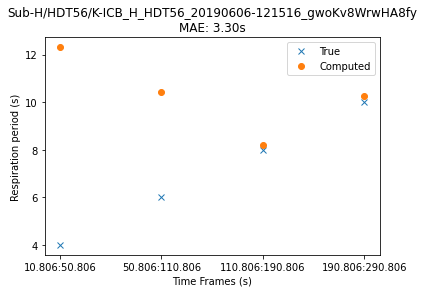

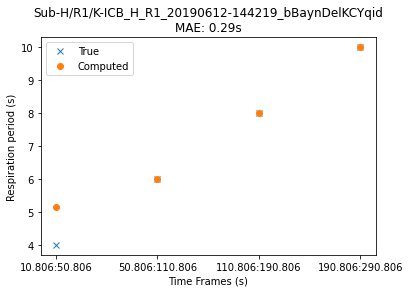

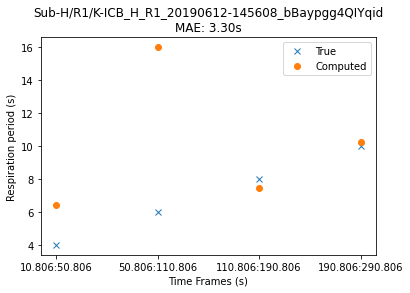

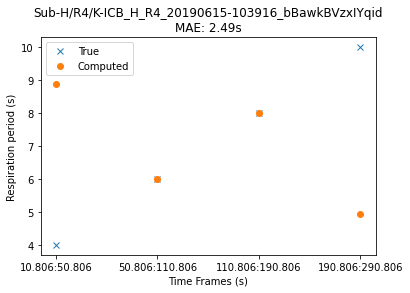

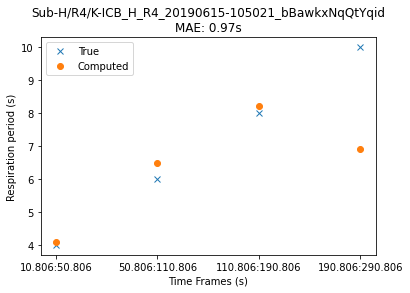

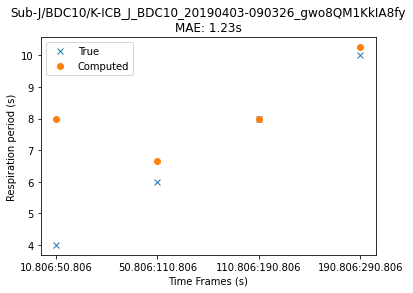

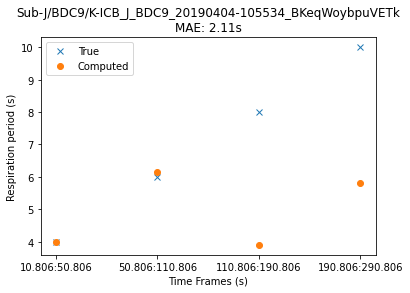

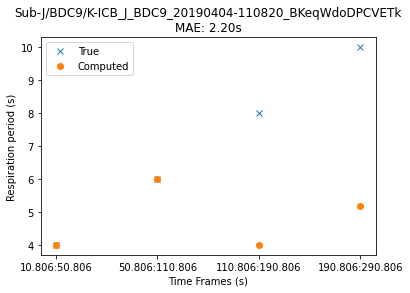

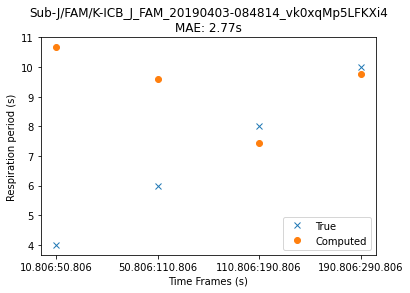

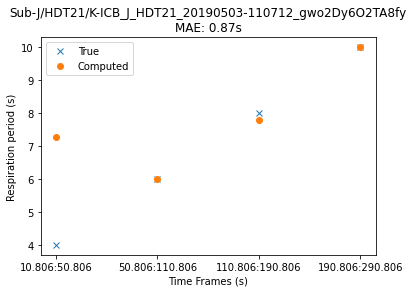

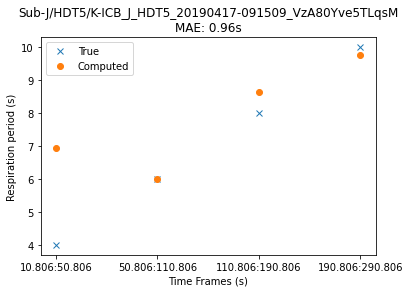

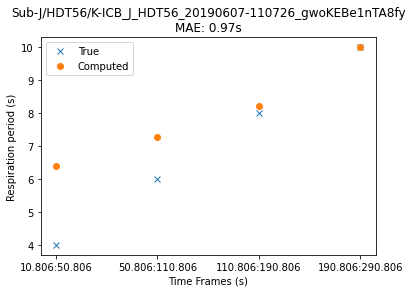

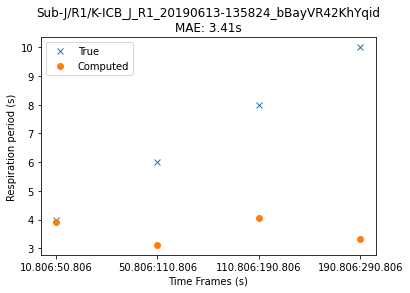

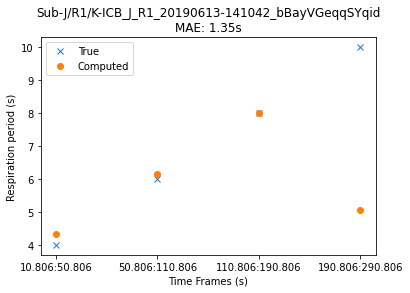

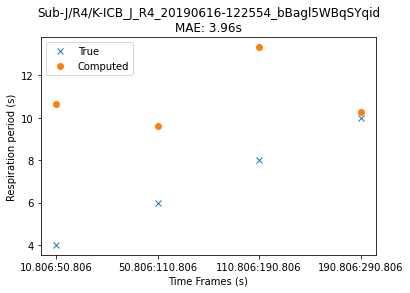

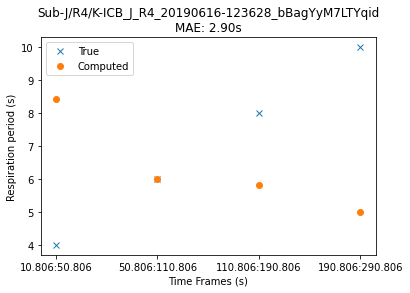

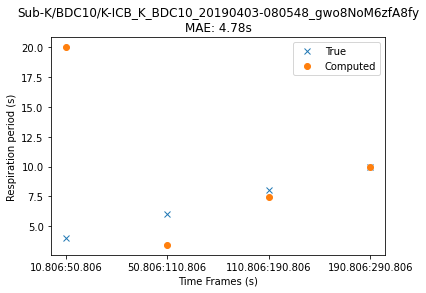

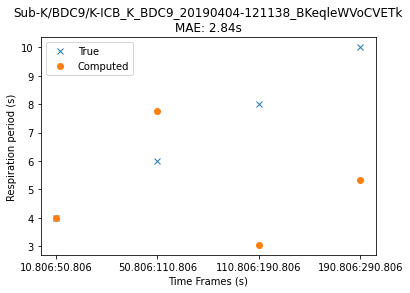

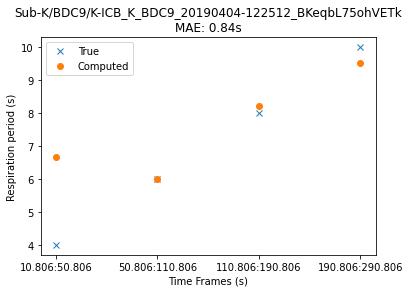

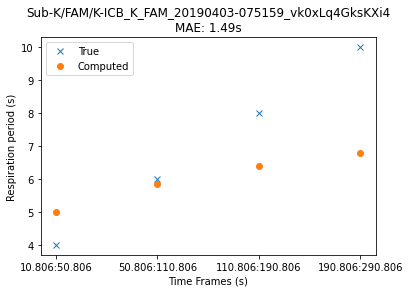

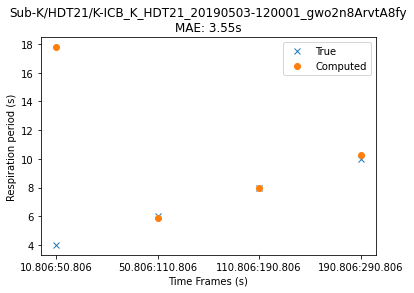

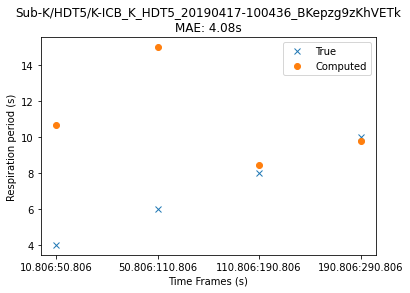

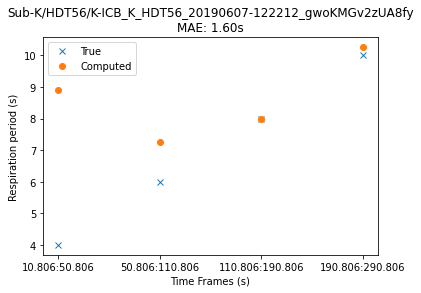

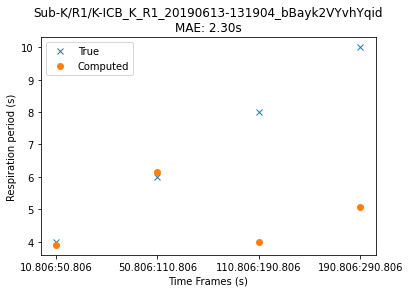

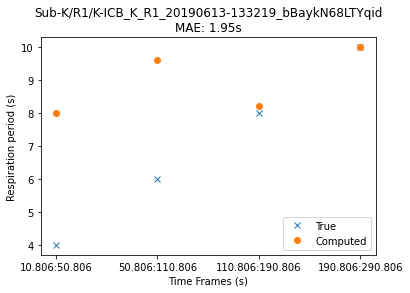

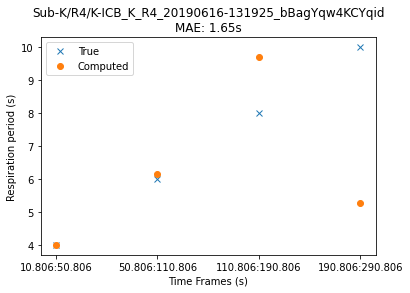

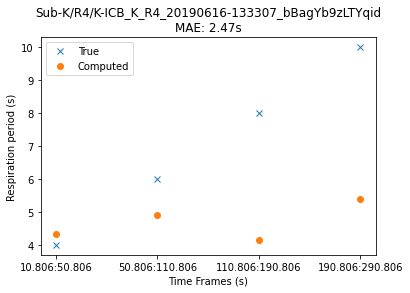

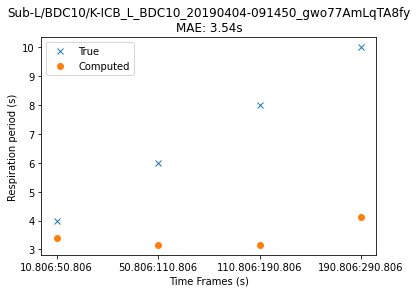

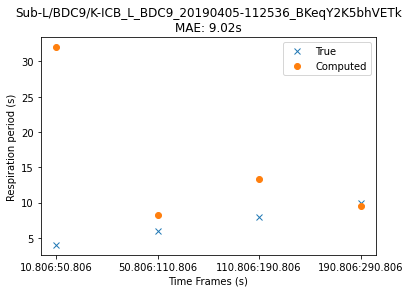

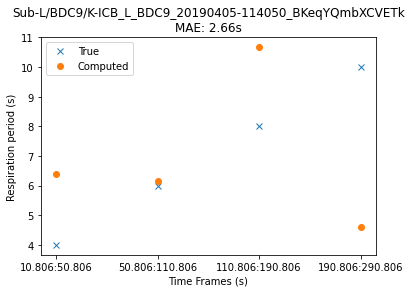

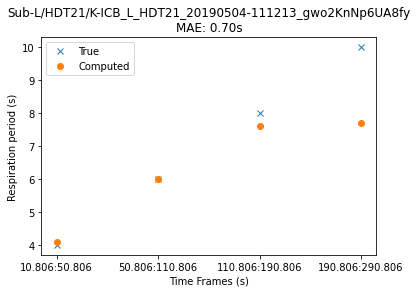

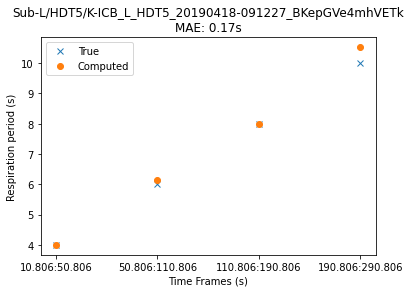

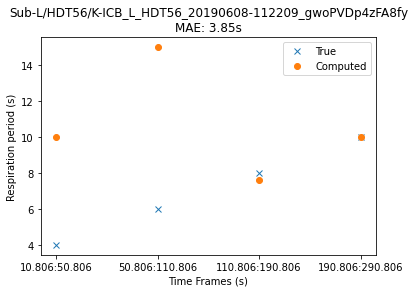

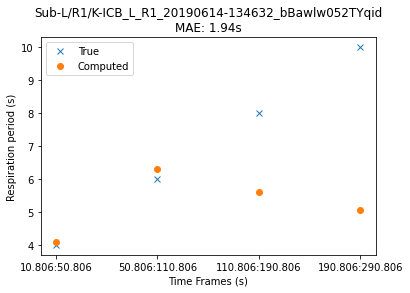

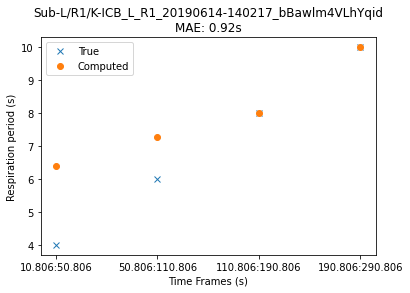

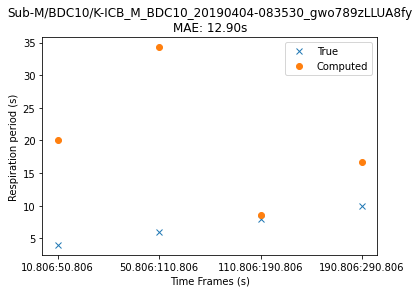

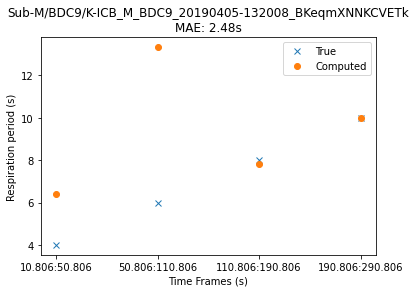

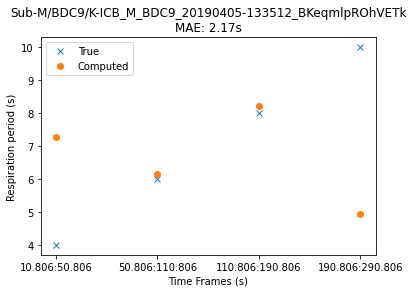

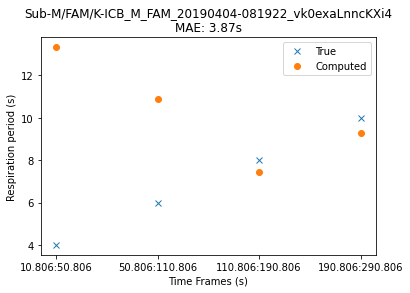

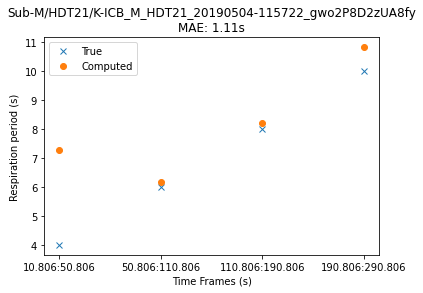

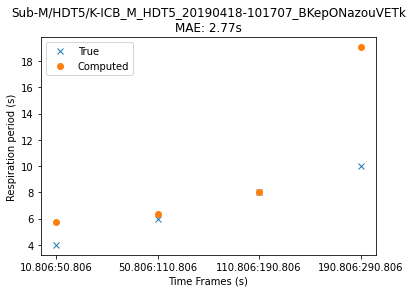

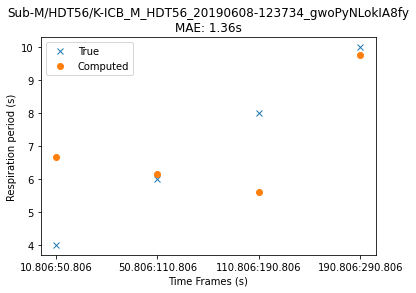

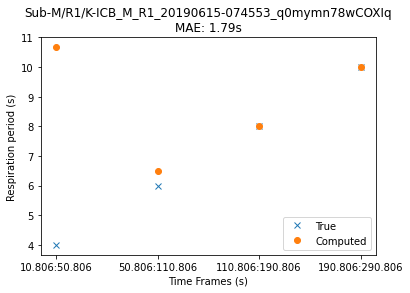

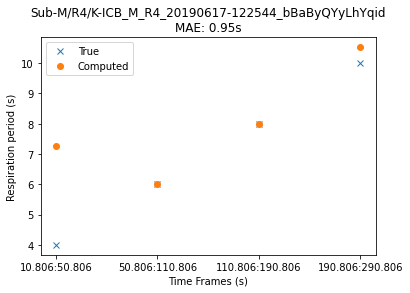

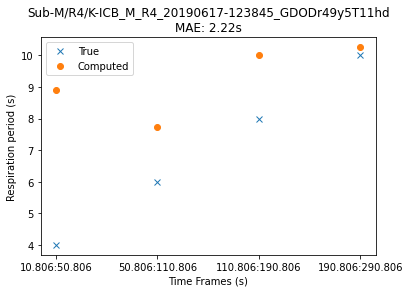

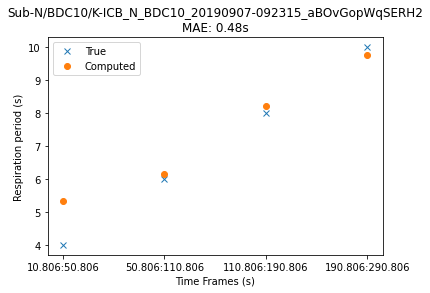

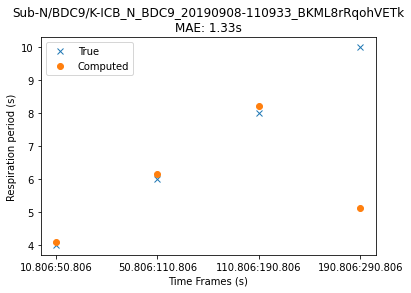

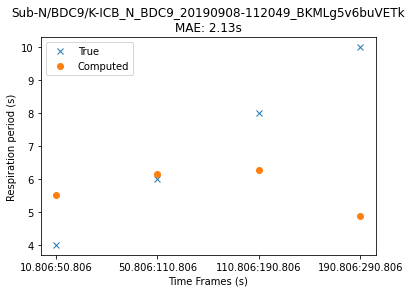

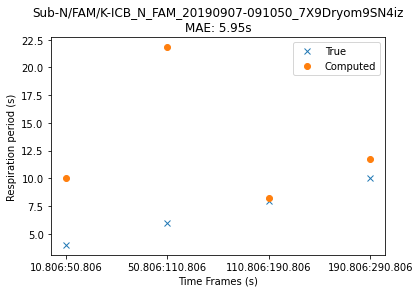

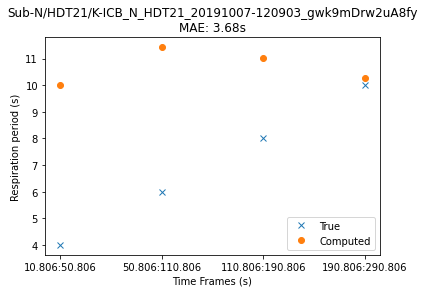

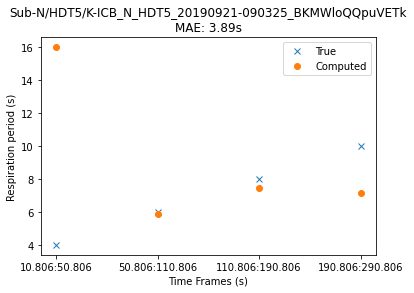

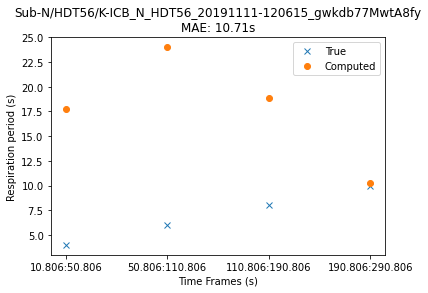

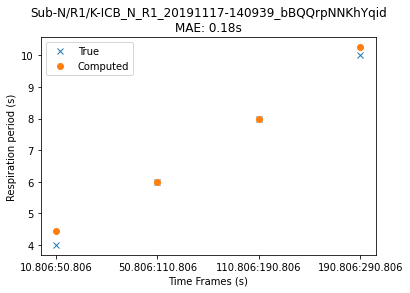

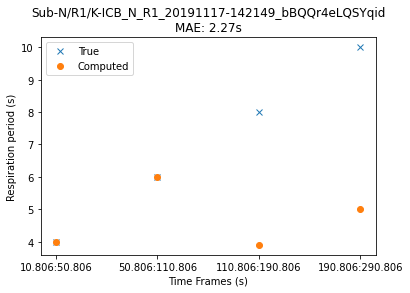

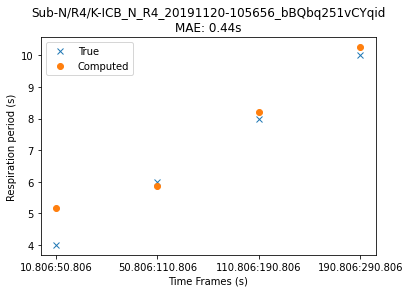

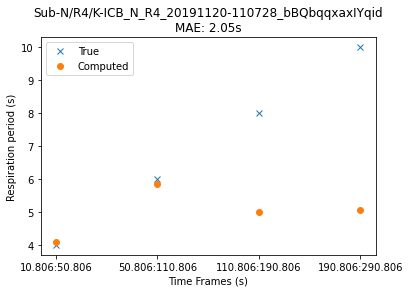

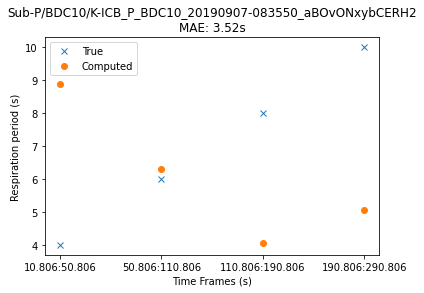

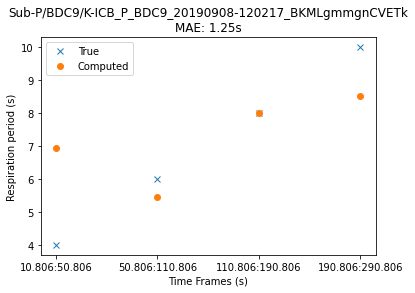

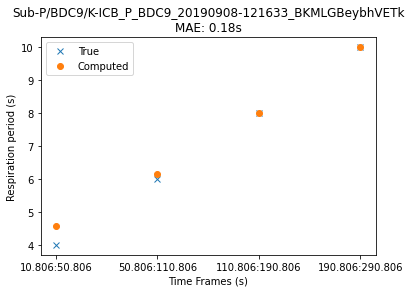

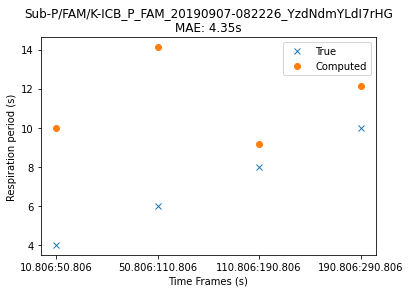

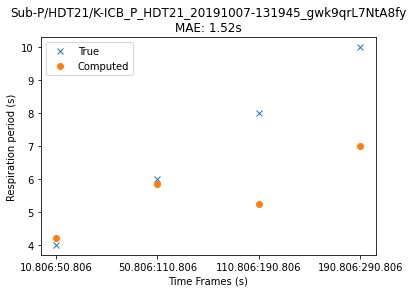

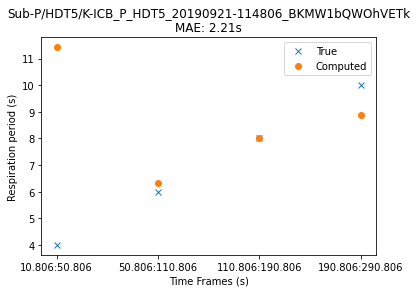

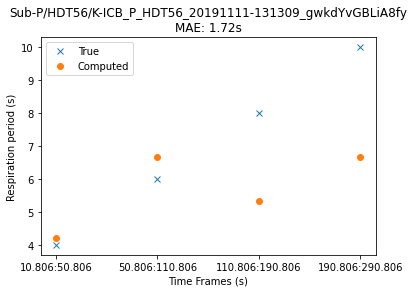

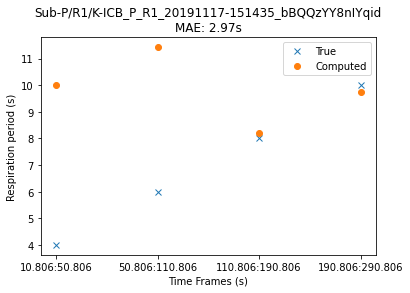

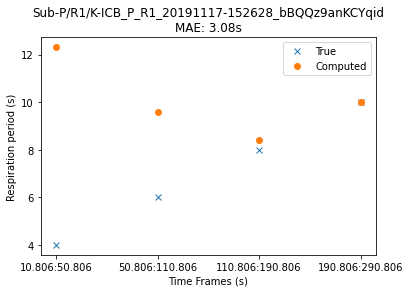

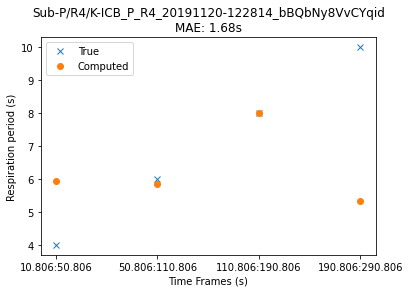

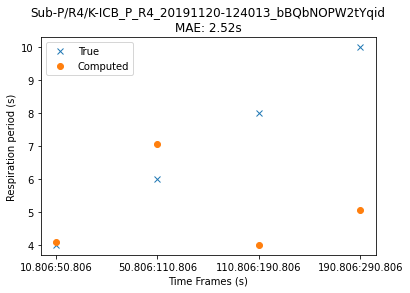

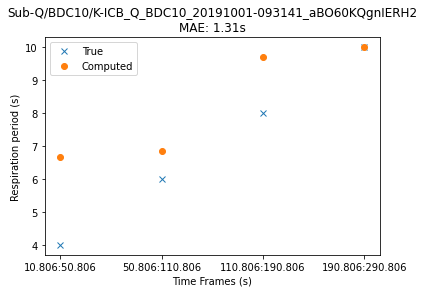

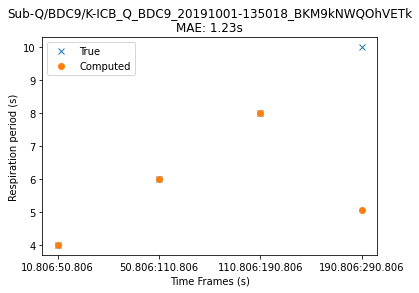

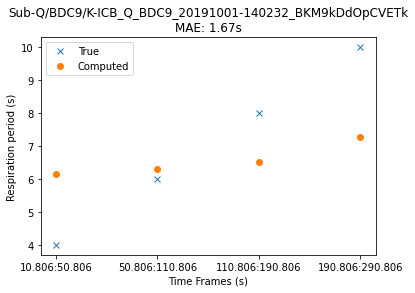

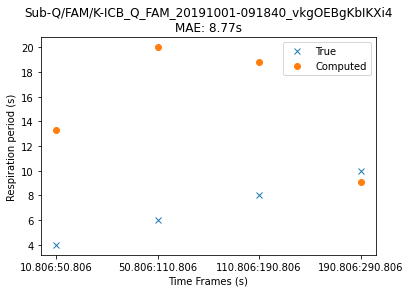

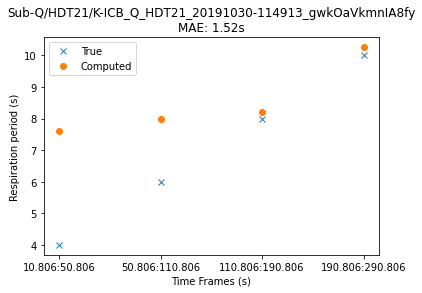

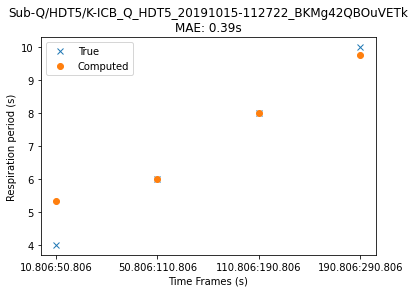

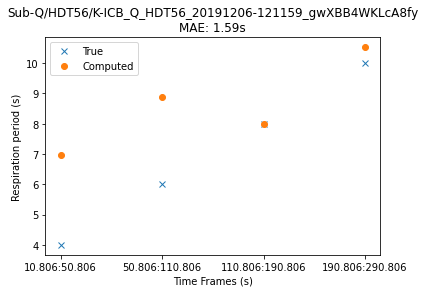

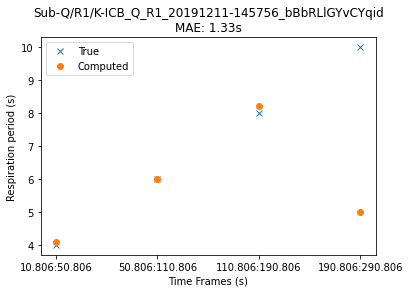

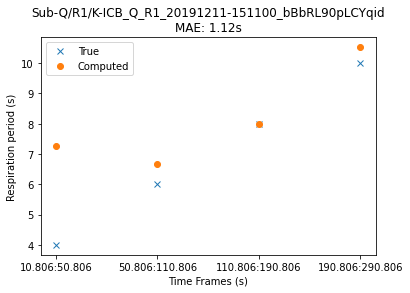

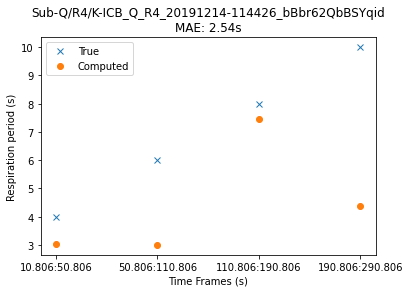

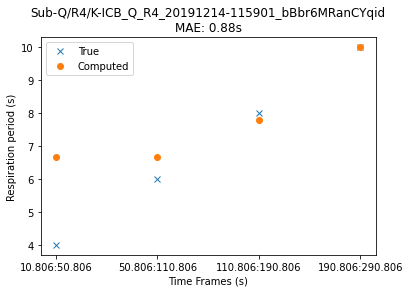

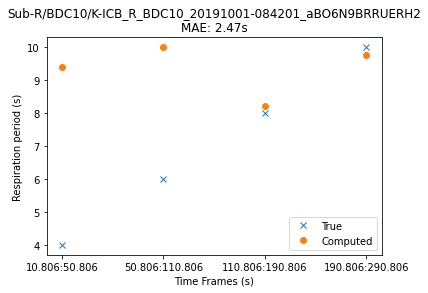

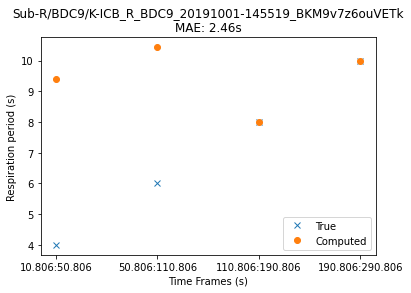

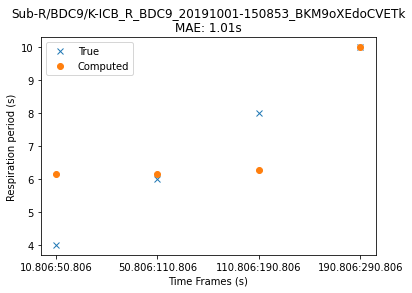

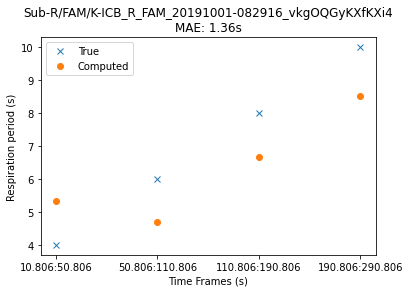

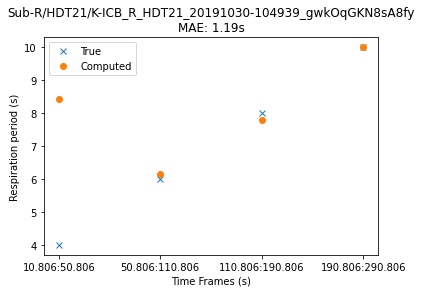

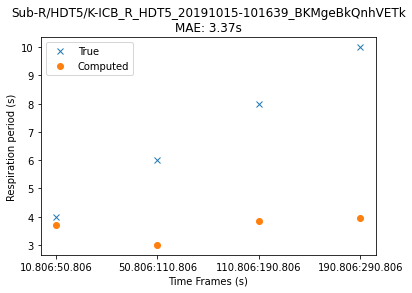

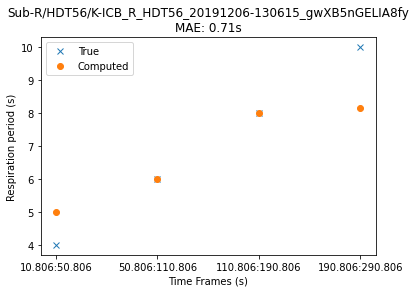

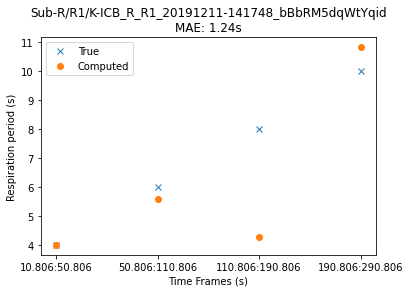

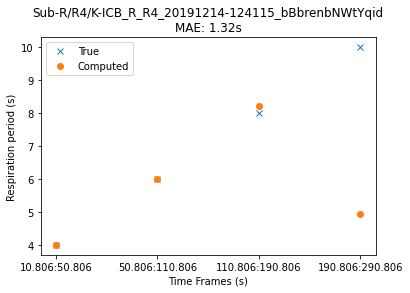

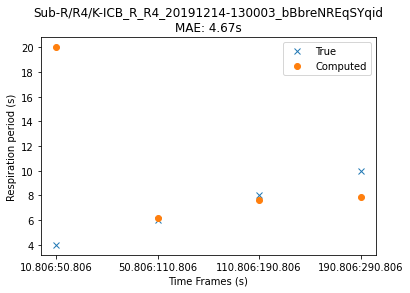

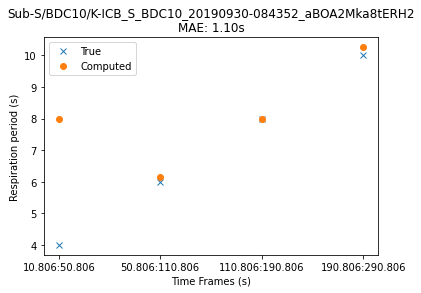

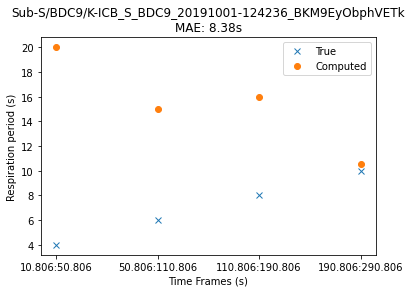

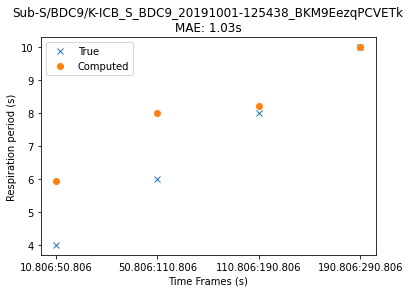

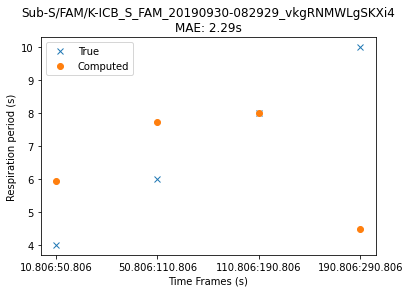

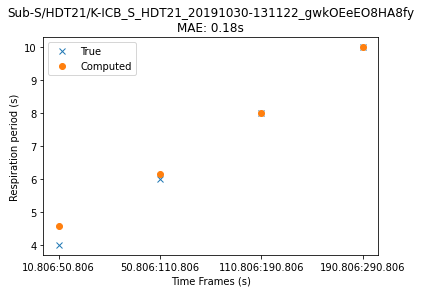

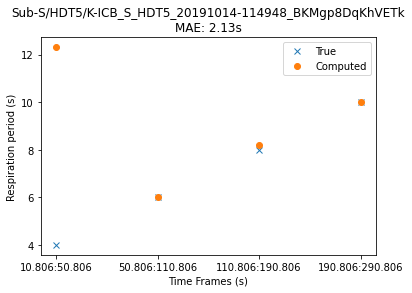

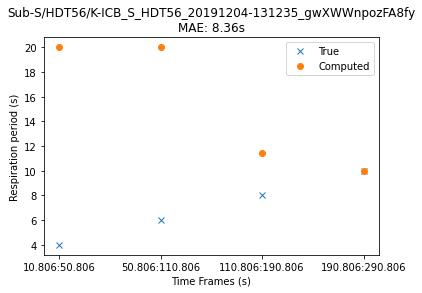

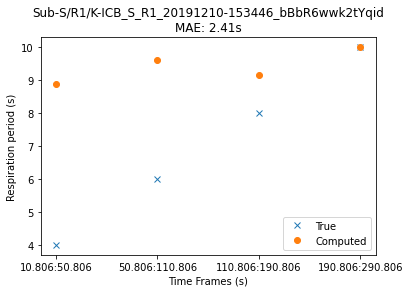

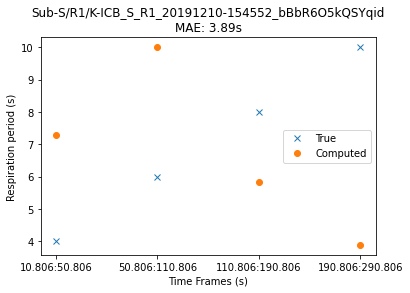

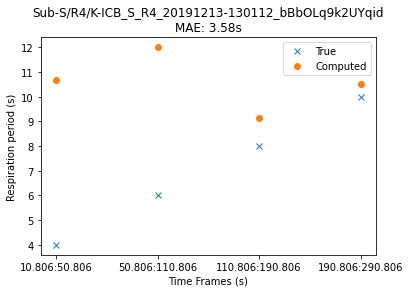

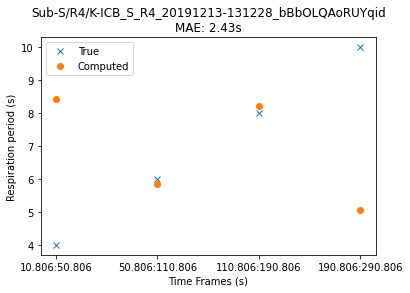

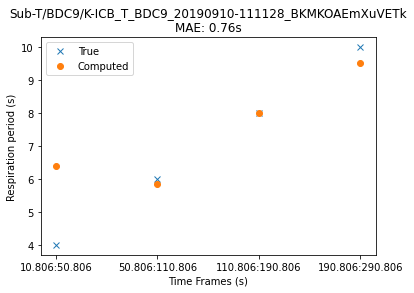

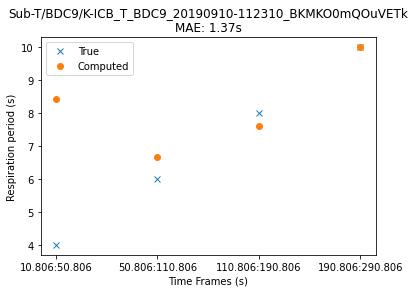

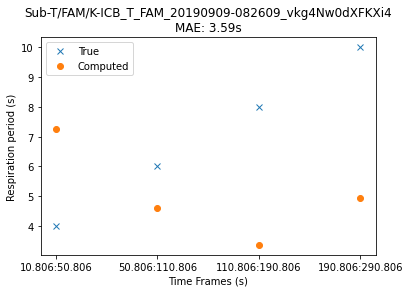

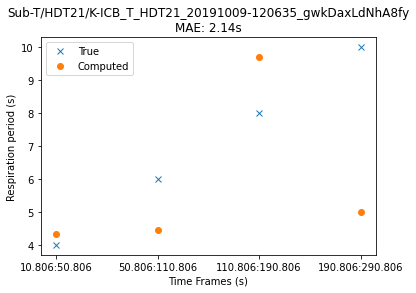

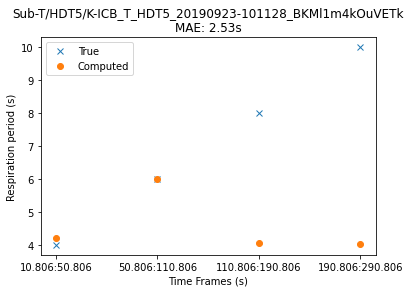

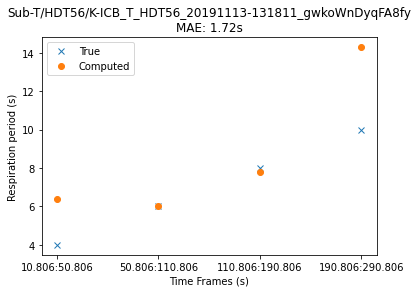

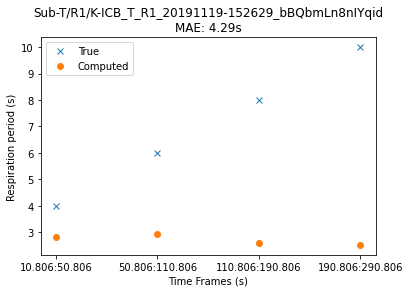

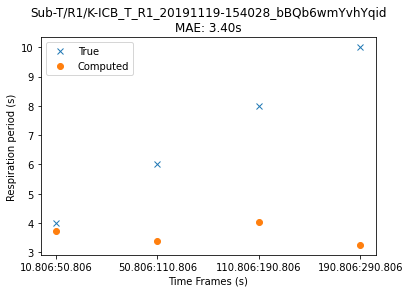

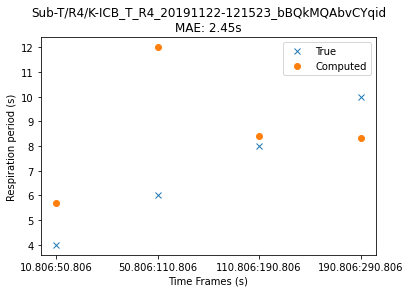

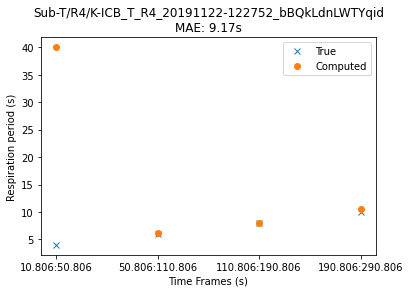

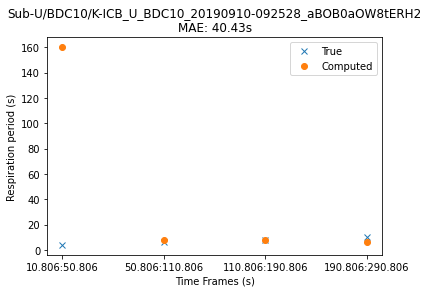

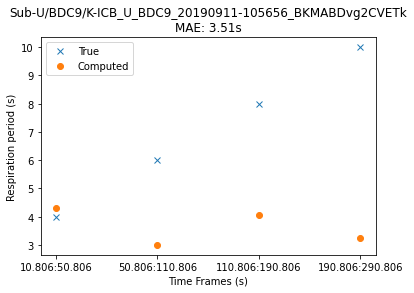

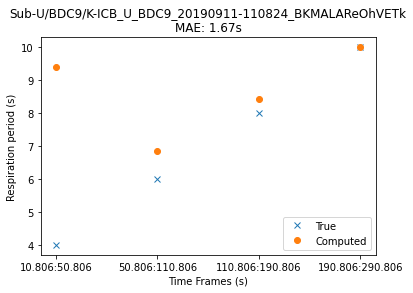

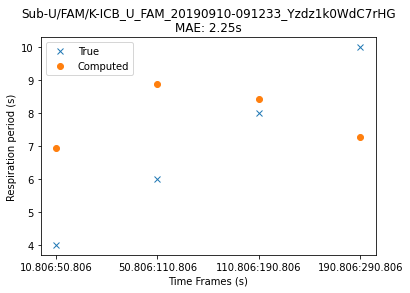

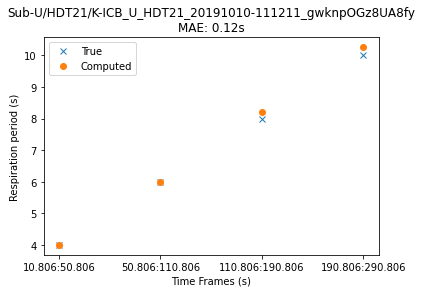

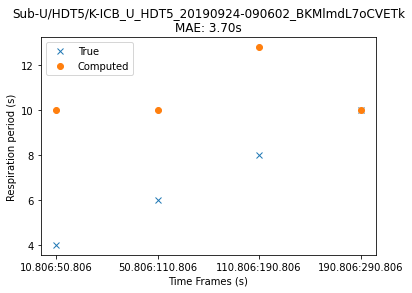

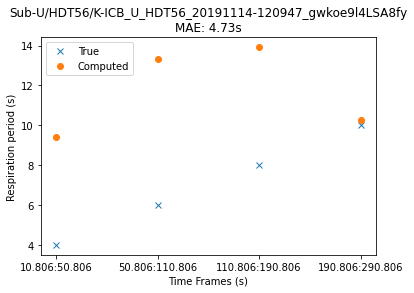

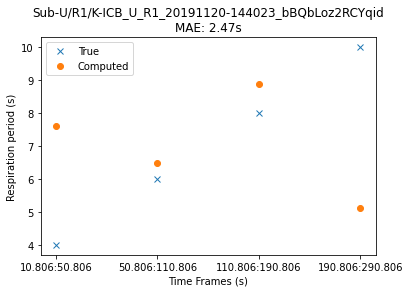

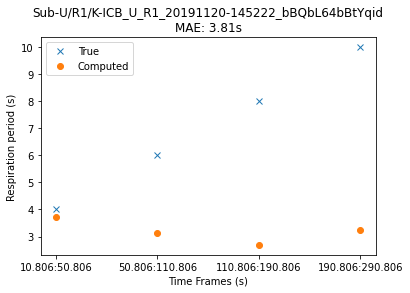

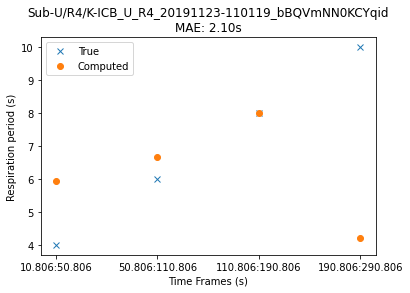

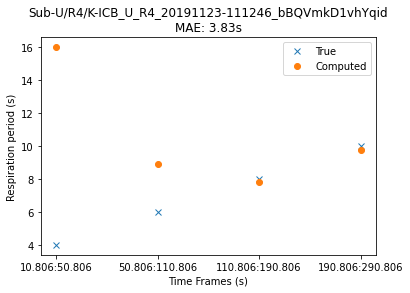

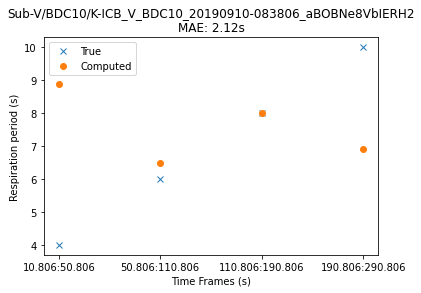

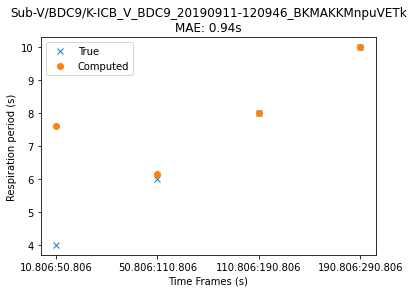

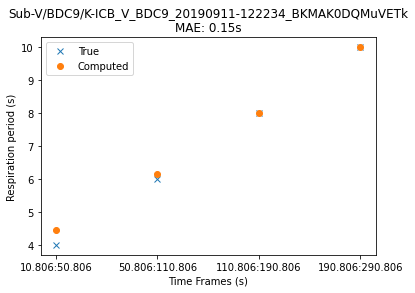

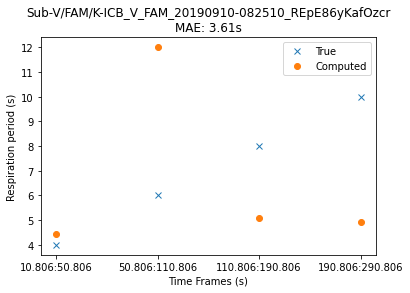

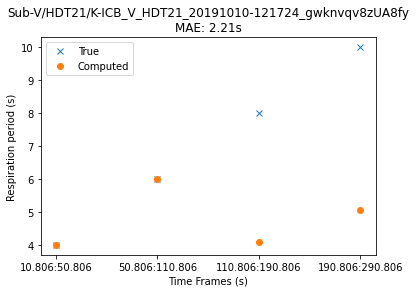

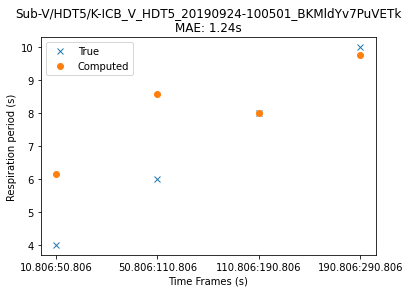

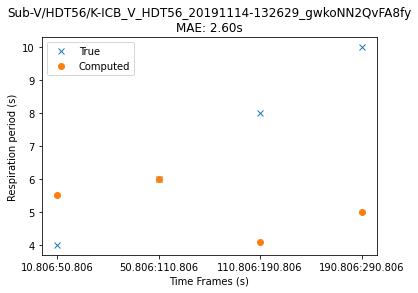

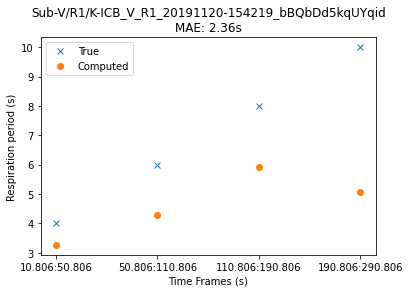

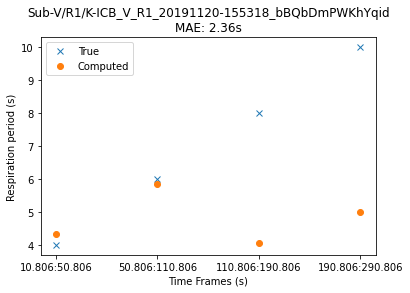

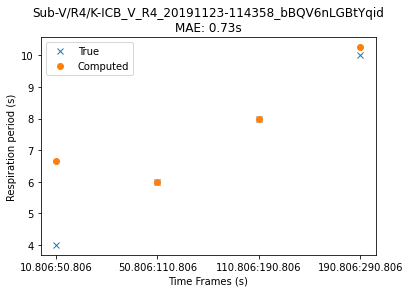

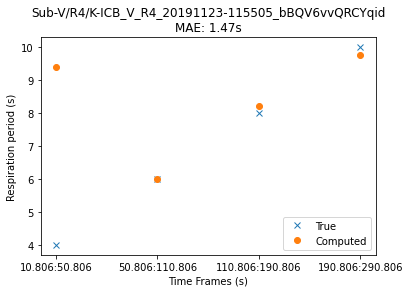

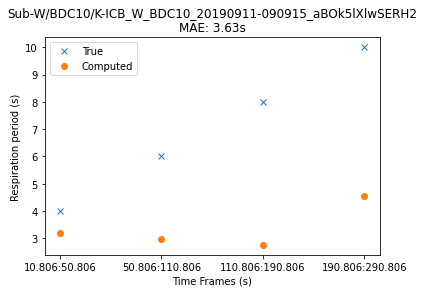

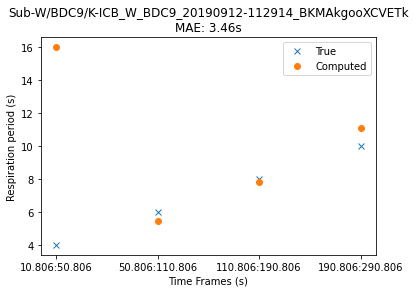

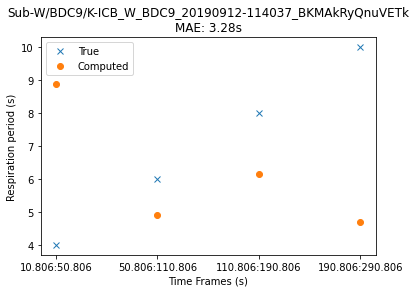

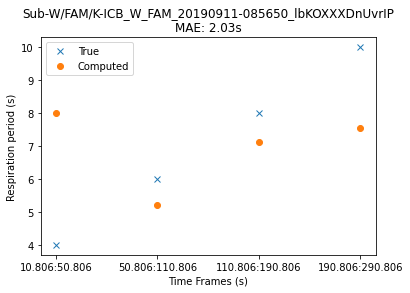

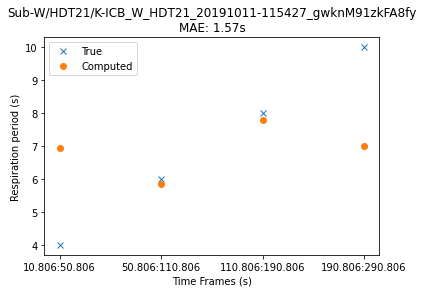

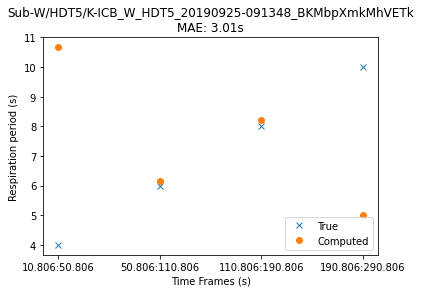

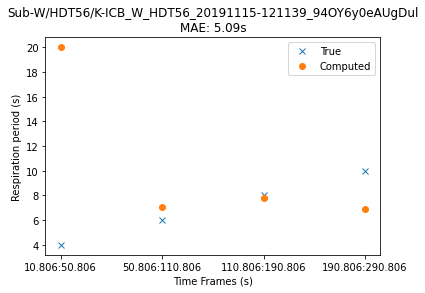

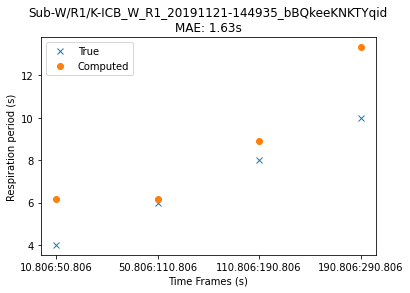

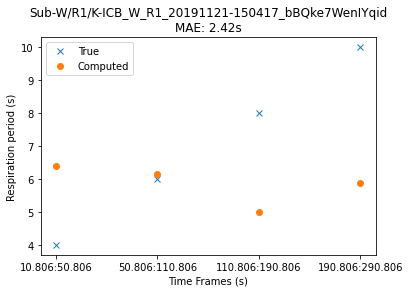

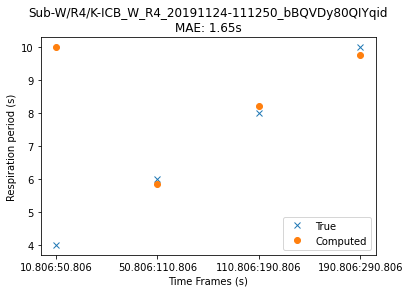

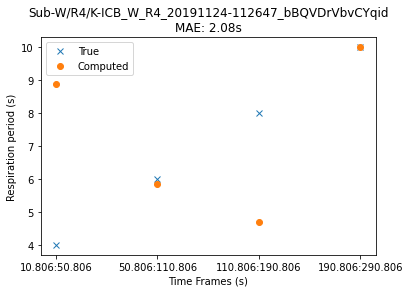

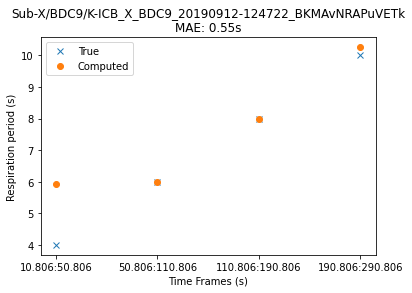

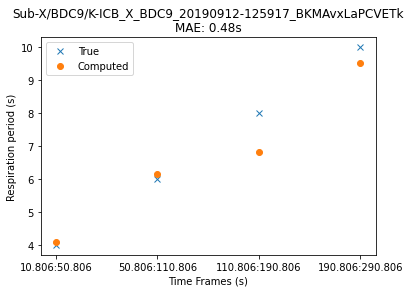

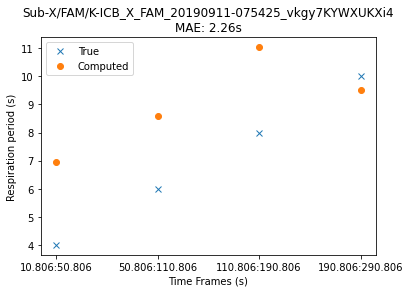

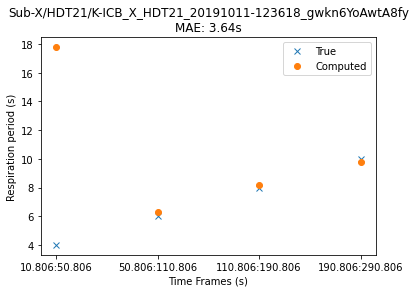

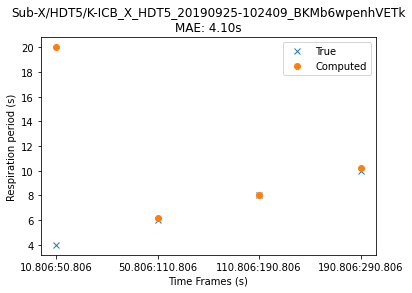

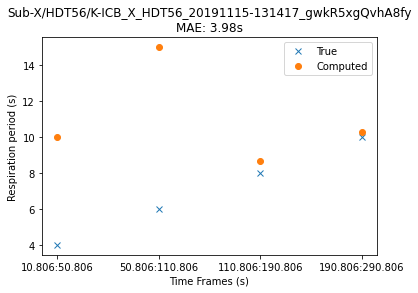

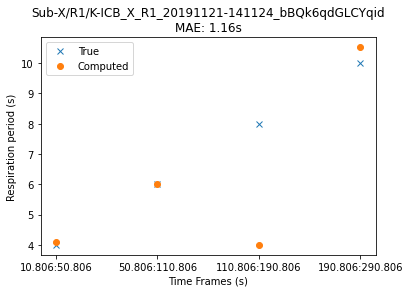

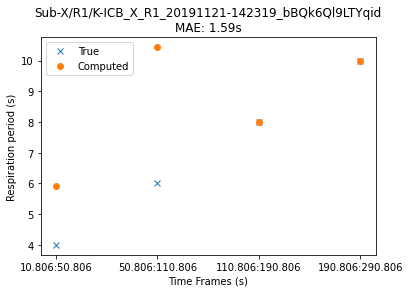

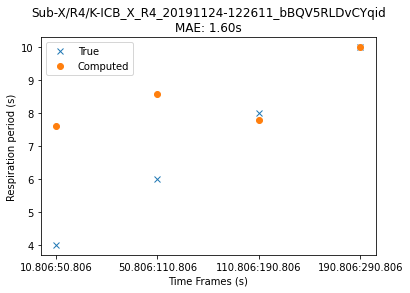

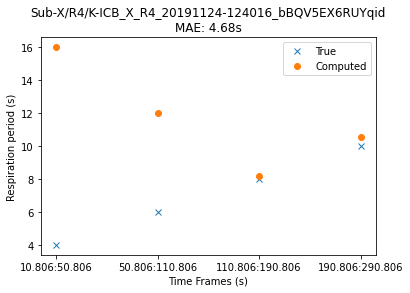

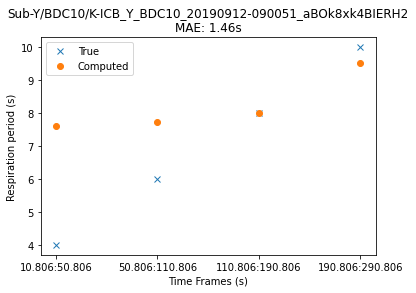

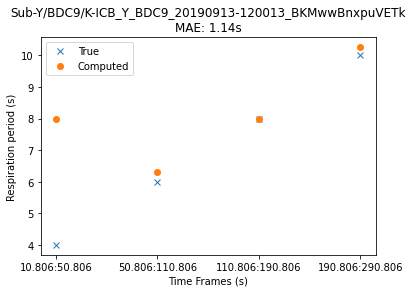

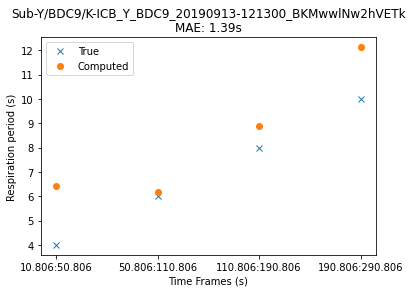

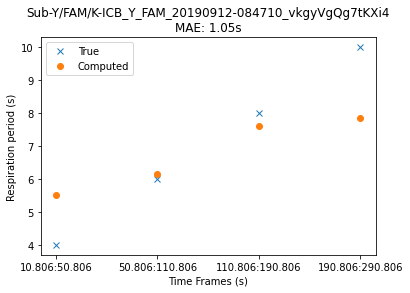

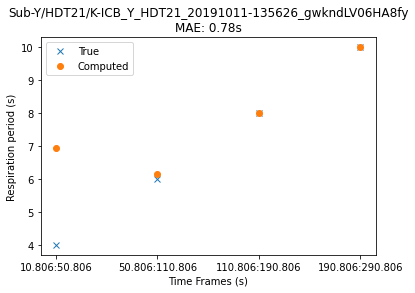

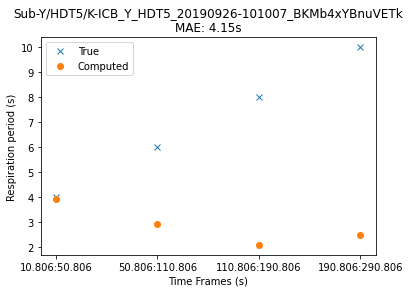

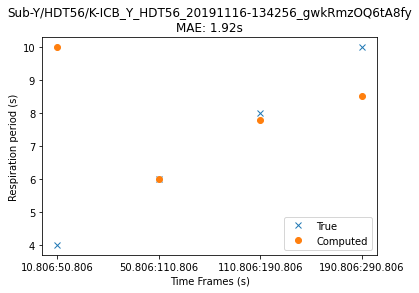

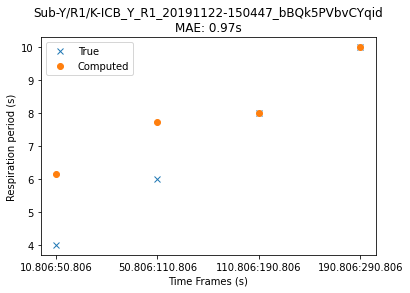

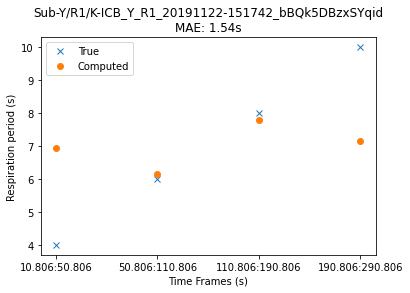

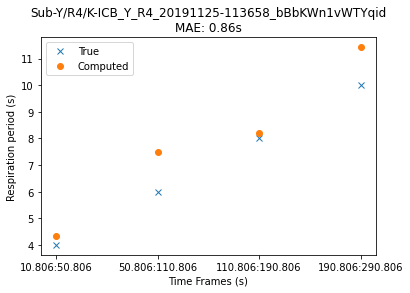

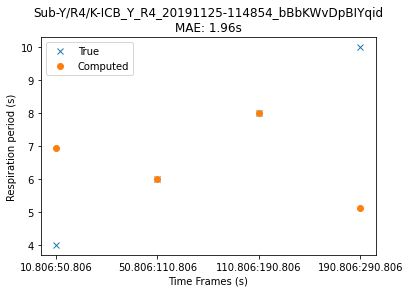

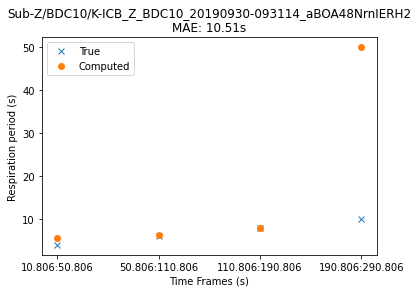

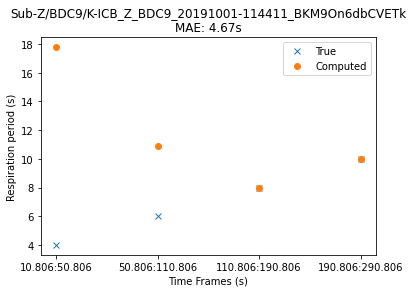

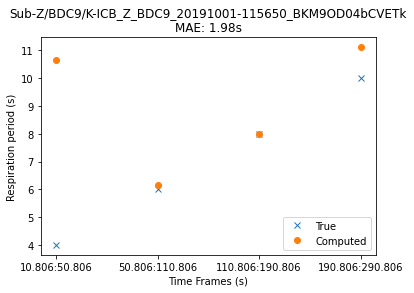

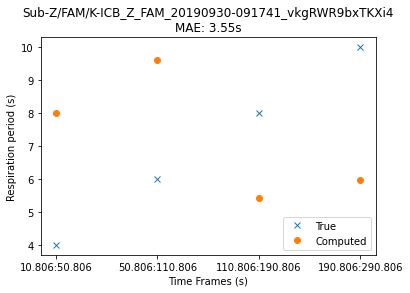

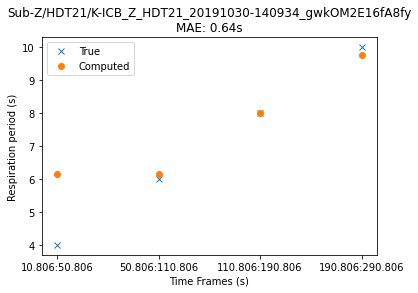

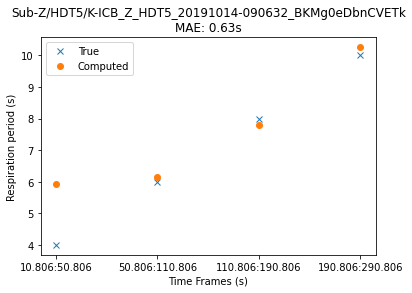

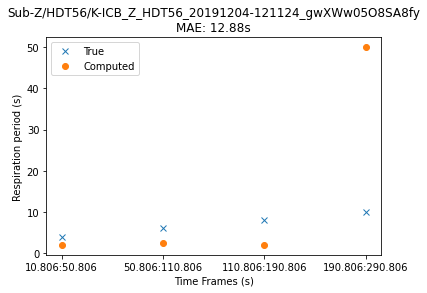

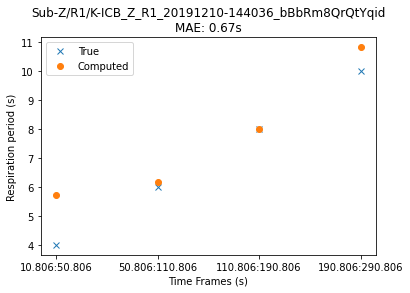

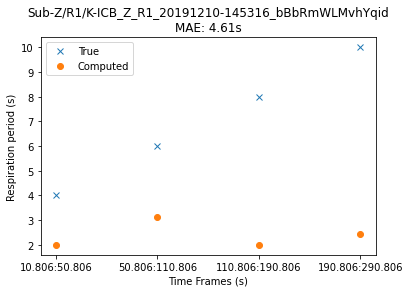

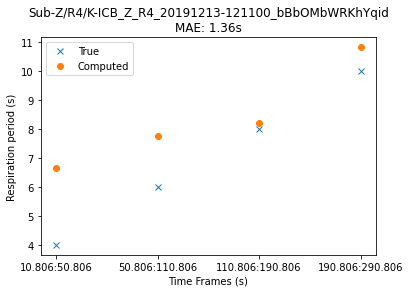

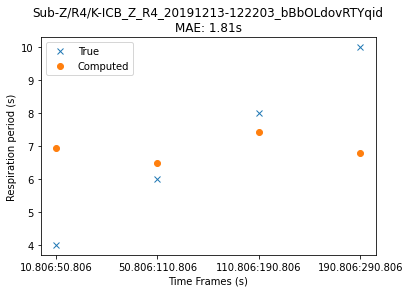

In [25]:
distance_ms = 1000
prominence = 0.25

sec_path_all = []
err_all = []

for idx, m in enumerate(path_all):
    print(idx)
    record = read_record(m)
    scg = record.signals["scg"]
    s6 = detrend(scg.vel[1][:,2])
    emd = EMD()
    IMFs = emd(s6)
    fmax_all = []
    for idk, k in enumerate(IMFs):
        nperseg = np.ceil(len(IMFs[idk]) / 2)
        f, P = welch(IMFs[idk]-np.mean(IMFs[idk]), fs=fs, window='hanning', nperseg=nperseg, nfft=8*nperseg, detrend='constant')
        Area = integrate.cumtrapz(P, f, initial=0)
        Ptotal = Area[-1]
        mpf = integrate.trapz(f * P, f) / Ptotal  # mean power frequency
        fmax = f[np.argmax(P)]
        # frequency percentiles
        inds = [0]
        Area = 100 * Area / Ptotal  # + 10 * np.finfo(np.float).eps
        for i in range(1, 101):
            inds.append(np.argmax(Area[inds[-1]:] >= i) + inds[-1])
        fpcntile = f[inds]
        fmax_all.append(fmax)
    fmax_all = np.array(fmax_all)
    indices = np.where([(x>=0.1) & (x<=0.7) for x in fmax_all])[0]
    fresp_cand = fmax_all[[(x>=0.1) & (x<=0.7) for x in fmax_all]]
    resp_cand = IMFs[[(x>=0.1) & (x<=0.7) for x in fmax_all]]
    f95_all = []
    for idk, k in enumerate(resp_cand):
        nperseg = np.ceil(len(resp_cand[idk]) / 2)
        f, P = welch(resp_cand[idk]-np.mean(resp_cand[idk]), fs=fs, window='hanning', nperseg=nperseg, nfft=8*nperseg, detrend='constant')
        Area = integrate.cumtrapz(P, f, initial=0)
        Ptotal = Area[-1]
        mpf = integrate.trapz(f * P, f) / Ptotal  # mean power frequency
        fmax = f[np.argmax(P)]
        # frequency percentiles
        inds = [0]
        Area = 100 * Area / Ptotal  # + 10 * np.finfo(np.float).eps
        for i in range(1, 101):
            inds.append(np.argmax(Area[inds[-1]:] >= i) + inds[-1])
        fpcntile = f[inds]
        f95_all.append(fpcntile[95])
    resp = resp_cand[np.argmin(f95_all)]
    nperseg = np.ceil(len(resp) / 2)
    f, P = welch(resp-np.mean(resp), fs=fs, window='hanning', nperseg=nperseg, nfft=8*nperseg, detrend='constant')
    Area = integrate.cumtrapz(P, f, initial=0)
    Ptotal = Area[-1]
    mpf = integrate.trapz(f * P, f) / Ptotal  # mean power frequency
    fmax = f[np.argmax(P)]
    # frequency percentiles
    inds = [0]
    Area = 100 * Area / Ptotal  # + 10 * np.finfo(np.float).eps
    for i in range(1, 101):
        inds.append(np.argmax(Area[inds[-1]:] >= i) + inds[-1])
    fpcntile = f[inds]
    resp = nk.rsp.rsp_clean(resp)
    resp = detrend(resp)
    resp = scale_normalization(resp, rg=(-1, 1))
    resp = scale_standardization_robust(resp)
    resp = _correct_rsp_sign(resp, fs, distance_ms=distance_ms, prominence=prominence)
    resp_period_all_comp = []
    for k in time_frames:
        resp_cut = resp[int(k[0]*fs):int(k[1]*fs)]
        fpcntile, mpf, fmax, Ptotal, f, P = psd2(resp_cut-np.mean(resp_cut), fs=fs, nfft=8*np.ceil(len(resp_cut)/2), show=False)
        if fmax==0:
            resp_period = 0
        else:
            resp_period = 1/fmax
        resp_period_all_comp.append(resp_period)
    main_path = os.path.normpath(m)
    sec_path = main_path.split(os.sep)
    sec_path = sec_path[7]+'/'+sec_path[8]+'/'+sec_path[9]
    sec_path_all.append(sec_path)
    resp_period_all_true = [4, 6, 8, 10]
    err = mean_absolute_error(resp_period_all_true, resp_period_all_comp)
    err_all.append(err)
    plt.figure()
    x = np.array([0,1,2,3])
    my_xticks = ['10.806:50.806','50.806:110.806','110.806:190.806','190.806:290.806']
    plt.xticks(x, my_xticks)
    plt.plot(my_xticks, resp_period_all_true, 'x')
    plt.plot(my_xticks, resp_period_all_comp, 'o')
    plt.xlabel('Time Frames (s)')
    plt.ylabel("Respiration period (s)")
    plt.legend(['True', 'Computed'])
    plt.title(sec_path+ '\nMAE: ' +str(format(err, ".2f"))+ 's')

Text(0, 0.5, 'MAE (s)')

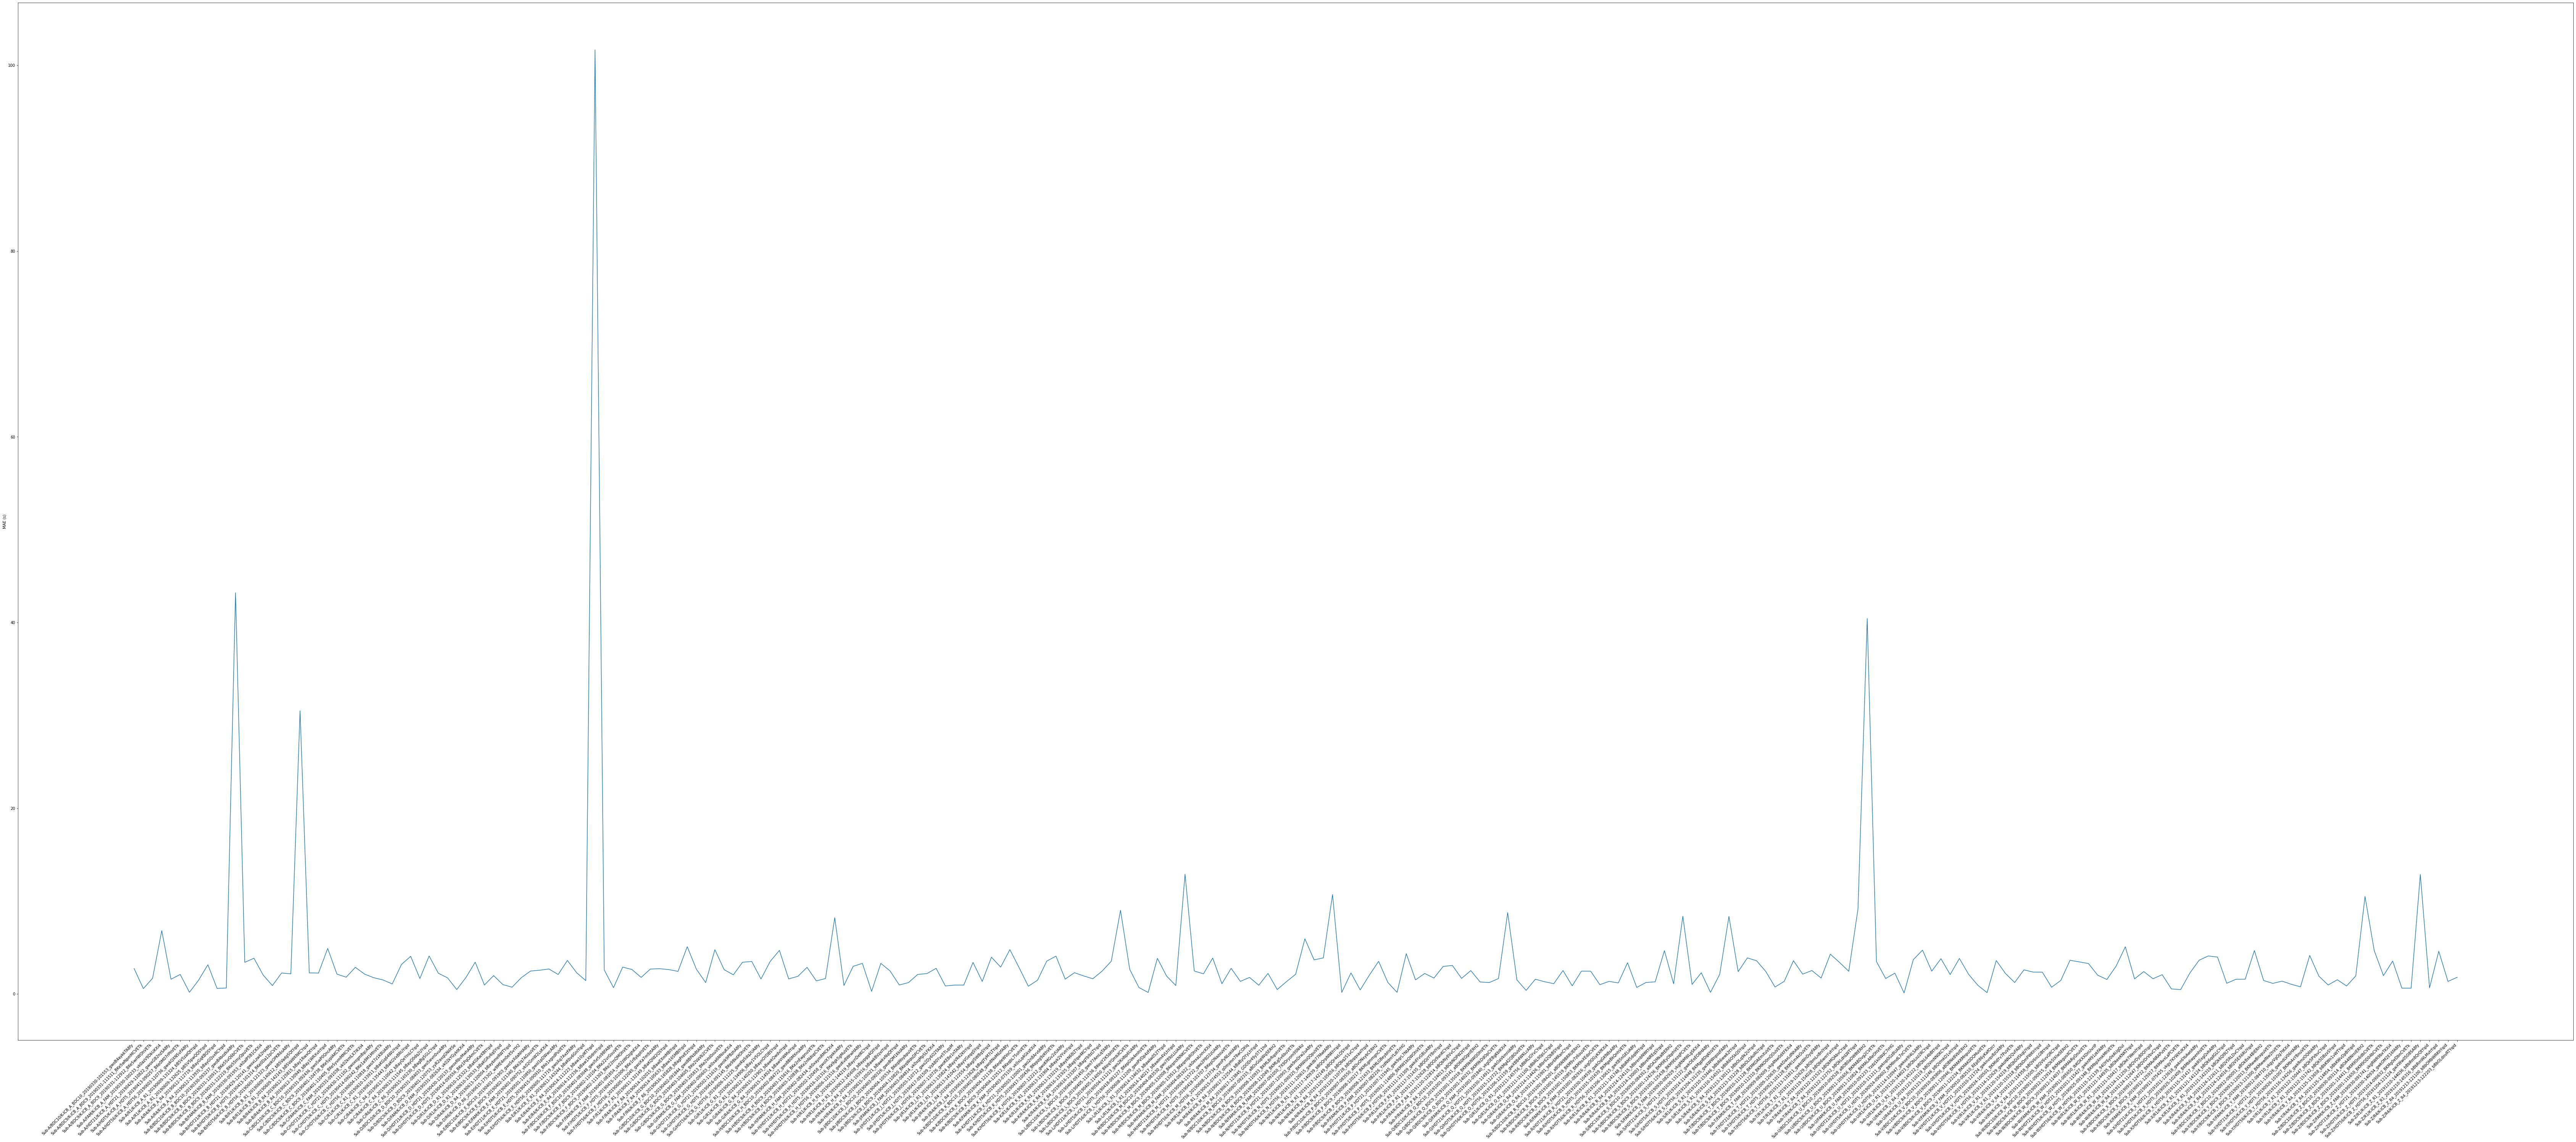

In [26]:
plt.figure(figsize=(120, 50))
x = np.array(range(len(sec_path_all)))
my_xticks = sec_path_all
plt.xticks(x, my_xticks, rotation=45, ha="right")
plt.plot(my_xticks, err_all)
plt.ylabel("MAE (s)")

In [27]:
import pickle

with open("/home/giuseppeditursi/Desktop/Respiration_from_SCG/2_Resp_Extraction/7_EMD/EMD_err_all", "wb") as fp:   #Pickling
    pickle.dump(err_all, fp)